In [1]:
# #To be used on cloud platforms

# ! python -c "import pykeen" || pip install pykeen
# ! python -c "import scprep" || pip install scprep

In [2]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import scanpy, networkx, scprep, magic, phate, scipy, DiffusionEMD, pygsp, torch, sklearn
import rpy2, rpy2.situation, anndata2ri
from localization import * #Wavelet module

In [3]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/Users/ferran/PhD/yaleCollab


In this notebook we will compute a wavelet dictionary on the NicheNet KG and KGE
using the 4 fibroblast cocults.

Rough outline will be to load individual Seurat->AnnData objects, check viz and metadata,
concat them all (keeping common genes). Also concat the metadata dataframes.

* Use the concat logcounts for KG matching and wavelet projection
* Metadata will be useful to review final embedding (see if we have any major batch efects)

# Data ingestion

## Load scRNAseq data

We will have to use rpy to import the seurat object with the data. From there we already have code (from RNA Velo NBs) to extract metadata. Need to extract count matrices.

In [4]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
Looking for R's HOME:
    Environment variable R_HOME: /Users/ferran/miniconda3/envs/collabLite/lib/R
    Calling `R RHOME`: /Users/ferran/miniconda3/envs/collabLite/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:
/usr/local/lib/R/library/stats/libs/:/usr/local/lib/R/library/stats/libs/
R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/Users/ferran/miniconda3/envs/collabLite/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/Users/ferran/miniconda3/envs/collabLite/lib', '/Users/ferran/miniconda3/envs/collabLite/lib/R/lib', '/Users/ferran/miniconda3/envs/collabLite/lib']
  extra_compile_args:
  []
  extra_lin

In [5]:
anndata2ri.activate() #This HAS TO be run b4 loading the rpy2 extension
%load_ext rpy2.ipython


In [6]:
%%R -i data_dir
library(tidyverse)
library(Seurat)

paste0(data_dir)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

R[write to console]: Attaching SeuratObject

R[write to console]: Attaching sp



[1] "/Users/ferran/PhD/yaleCollab/data"


In [7]:
%%R -o d_fibWT,d_fibA,d_fibAK,d_fibAKP,dPHATEcoord_WT,dPHATEcoord_A,dPHATEcoord_AK,dPHATEcoord_AKP

d_fibWT = readRDS(paste0(data_dir,"/Omics/","d_fibWT.rds"))
d_fibWT@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibWT)
#Export PHATE coordinates
dPHATEcoord_WT = as.data.frame(Embeddings(d_fibWT, reduction = "phate"))
#Convert seurat object to anndata
d_fibWT = as.SingleCellExperiment(d_fibWT)

d_fibA = readRDS(paste0(data_dir,"/Omics/","d_fibA.rds"))
d_fibA@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibA)
#Export PHATE coordinates
dPHATEcoord_A = as.data.frame(Embeddings(d_fibA, reduction = "phate"))
#Convert seurat object to anndata
d_fibA = as.SingleCellExperiment(d_fibA)

d_fibAK = readRDS(paste0(data_dir,"/Omics/","d_fibAK.rds"))
d_fibAK@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibAK)
#Export PHATE coordinates
dPHATEcoord_AK = as.data.frame(Embeddings(d_fibAK, reduction = "phate"))
#Convert seurat object to anndata
d_fibAK = as.SingleCellExperiment(d_fibAK)

d_fibAKP = readRDS(paste0(data_dir,"/Omics/","d_fibAKP.rds"))
d_fibAKP@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibAKP)
#Export PHATE coordinates
dPHATEcoord_AKP = as.data.frame(Embeddings(d_fibAKP, reduction = "phate"))
#Convert seurat object to anndata
d_fibAKP = as.SingleCellExperiment(d_fibAKP)


An object of class Seurat 
40940 features across 3698 samples within 2 assays 
Active assay: RNA (20867 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate
An object of class Seurat 
40964 features across 3646 samples within 2 assays 
Active assay: RNA (20923 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate
An object of class Seurat 
39062 features across 3391 samples within 2 assays 
Active assay: RNA (19919 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate
An object of class Seurat 
40650 features across 3811 samples within 2 assays 
Active assay: RNA (20786 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate


/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


In [8]:
list_RnaSeq = [d_fibWT,d_fibA,d_fibAK,d_fibAKP]
list_PHATEcoord = [dPHATEcoord_WT,dPHATEcoord_A,dPHATEcoord_AK,dPHATEcoord_AKP]

del d_fibWT,d_fibA,d_fibAK,d_fibAKP,dPHATEcoord_WT,dPHATEcoord_A,dPHATEcoord_AK,dPHATEcoord_AKP

In [9]:
for i in range(len(list_RnaSeq)):
    print(i)
    print(list_RnaSeq[i])
    print(list_PHATEcoord[i])

0
AnnData object with n_obs × n_vars = 3698 × 20867
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'mito_content', 'rfp_content', 'gfp_content', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CCDiff', 'SCT_snn_res.0.6', 'seurat_clusters', 'curatedCLUST', 'old.clust', 'finalPOPS', 'ident'
    layers: 'logcounts'
                         PHATE_1   PHATE_2
WT__AAACCCACAGCTTCCT-1 -0.018518 -0.001424
WT__AAACCCAGTTCGAGCC-1 -0.019244 -0.003914
WT__AAACGAAAGAAGGATG-1 -0.020449 -0.003372
WT__AAACGAAAGGAAAGGT-1  0.031038  0.002025
WT__AAACGAAAGTTAACGA-1  0.026724 -0.003324
...                          ...       ...
WT__TTTGGTTTCATTCTTG-1  0.016370  0.001419
WT__TTTGGTTTCCGTAGTA-1 -0.018737 -0.003385
WT__TTTGTTGTCGCTTGAA-1  0.030721  0.000984
WT__TTTGTTGTCTGAATCG-1 -0.008438  0.016301
WT__TTTGTTGTCTGGGTCG-1  0.029887 -0.004444

[3698 rows x 2 columns]
1
AnnData object with n_obs × n_vars = 3646 × 20923
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'mito

In [10]:
list_RnaSeq[1].obs["orig.ident"][0]


'cocultAFib'

View Object and metadata

AxisArrays with keys: 
Before filtering the object we have 20867 genes


/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


After filtering genes expressed in fewer than 4 cells we have 20666
AxisArrays with keys: 
Before filtering the object we have 20923 genes


/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


After filtering genes expressed in fewer than 4 cells we have 20542
AxisArrays with keys: 
Before filtering the object we have 19919 genes


/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


After filtering genes expressed in fewer than 4 cells we have 19599
AxisArrays with keys: 
Before filtering the object we have 20786 genes


/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


After filtering genes expressed in fewer than 4 cells we have 20267


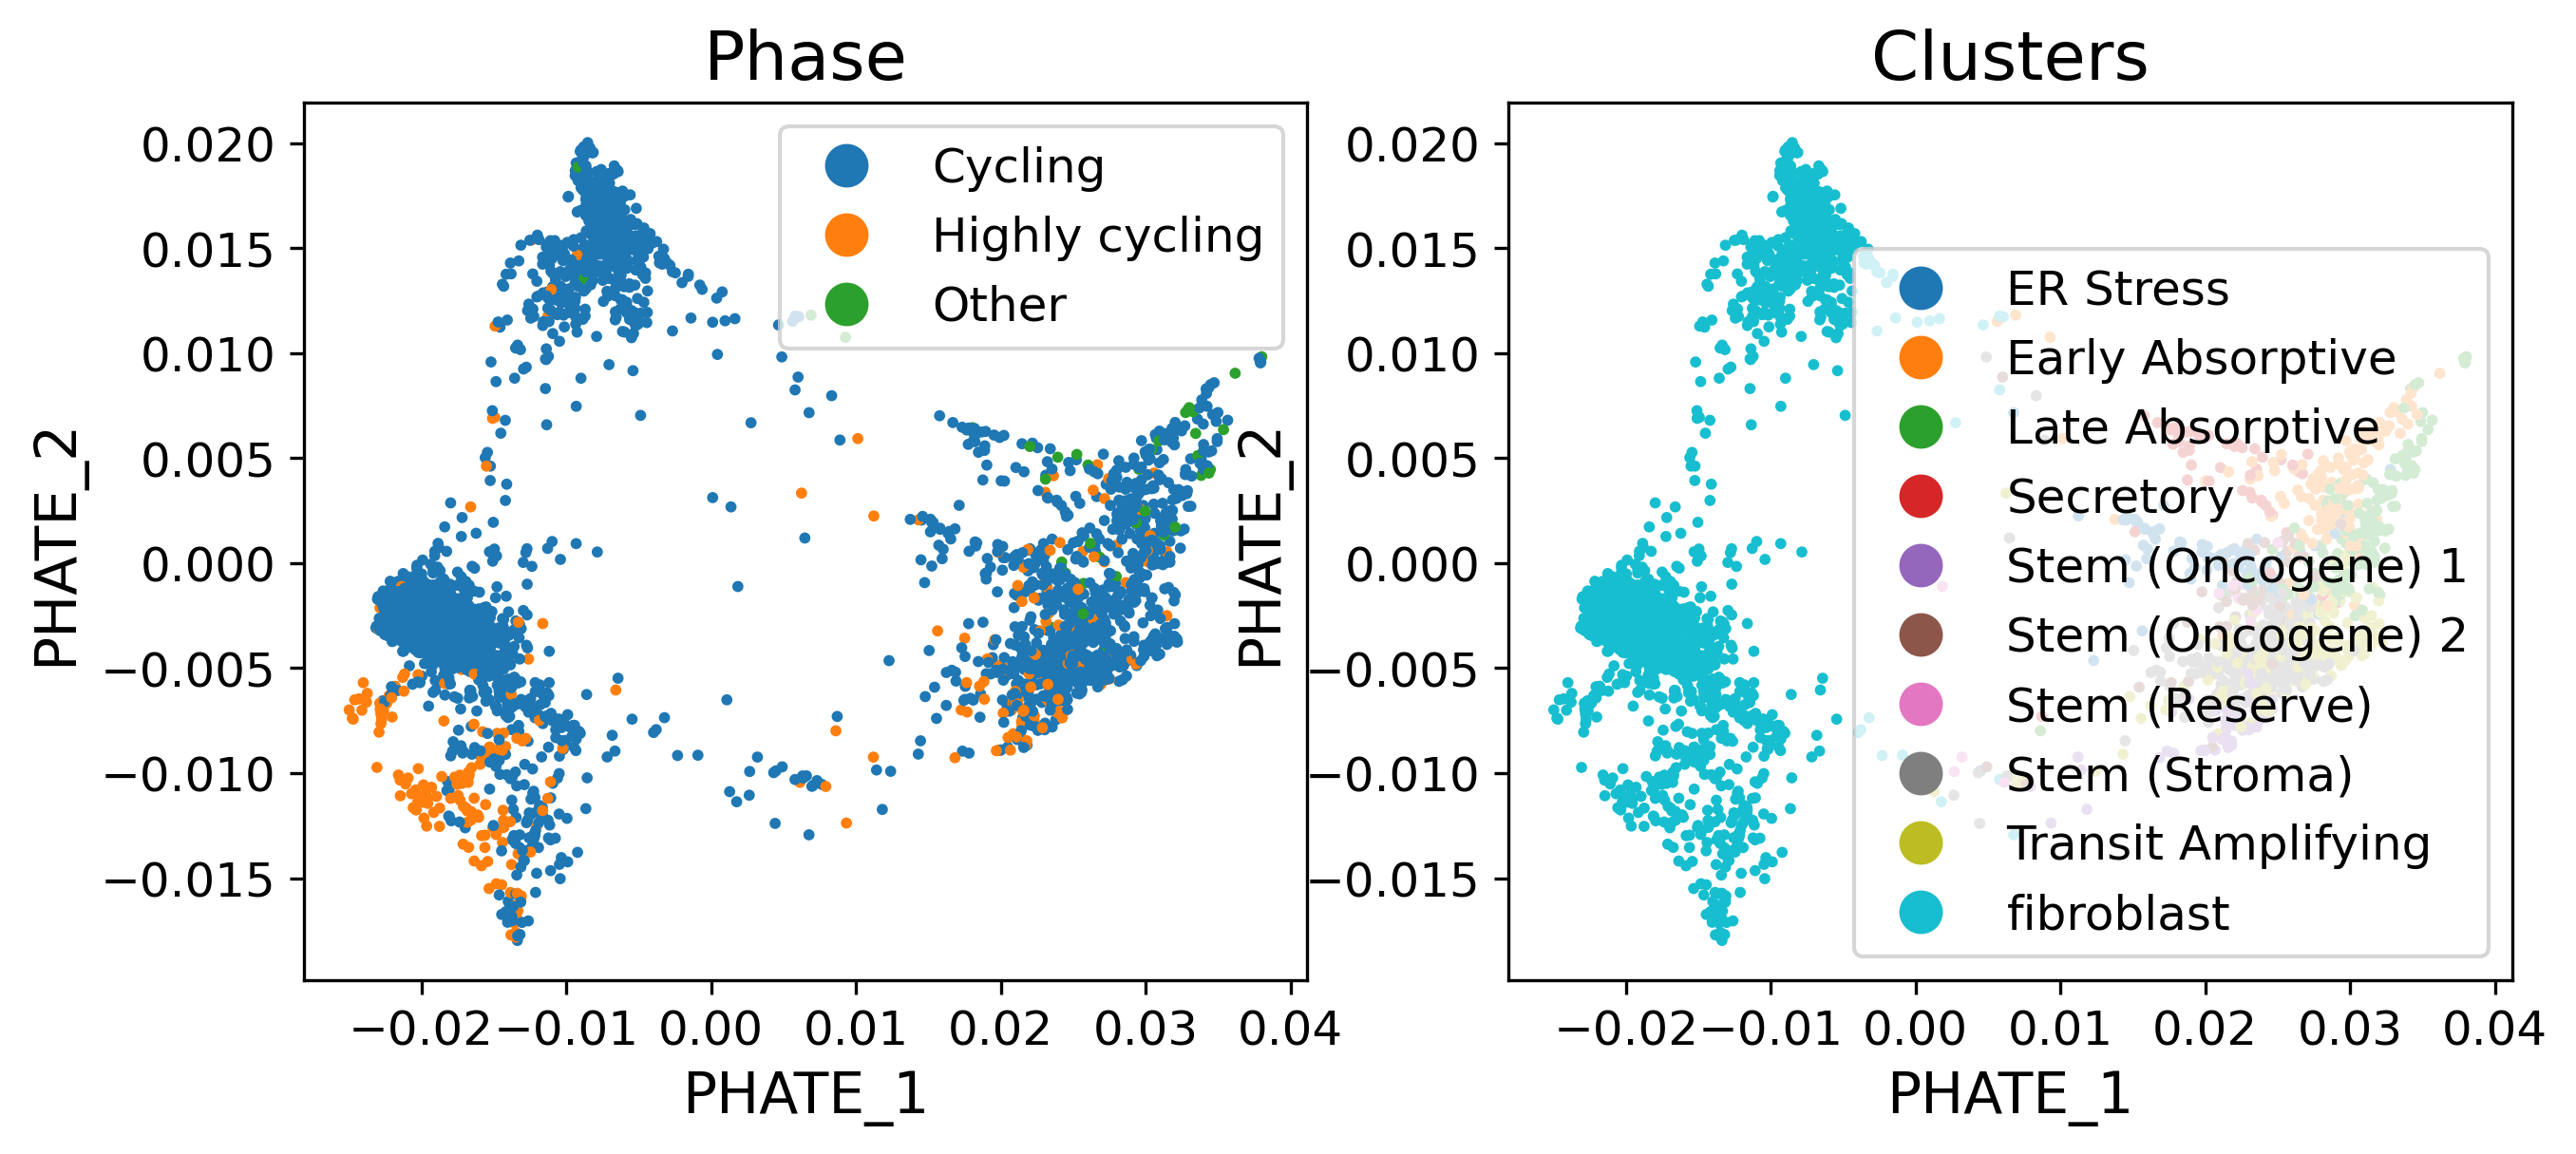

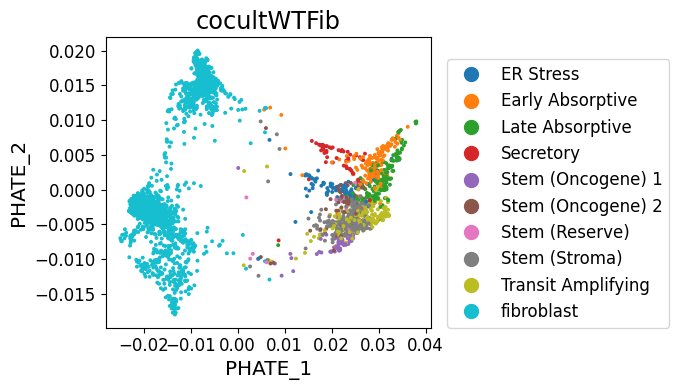

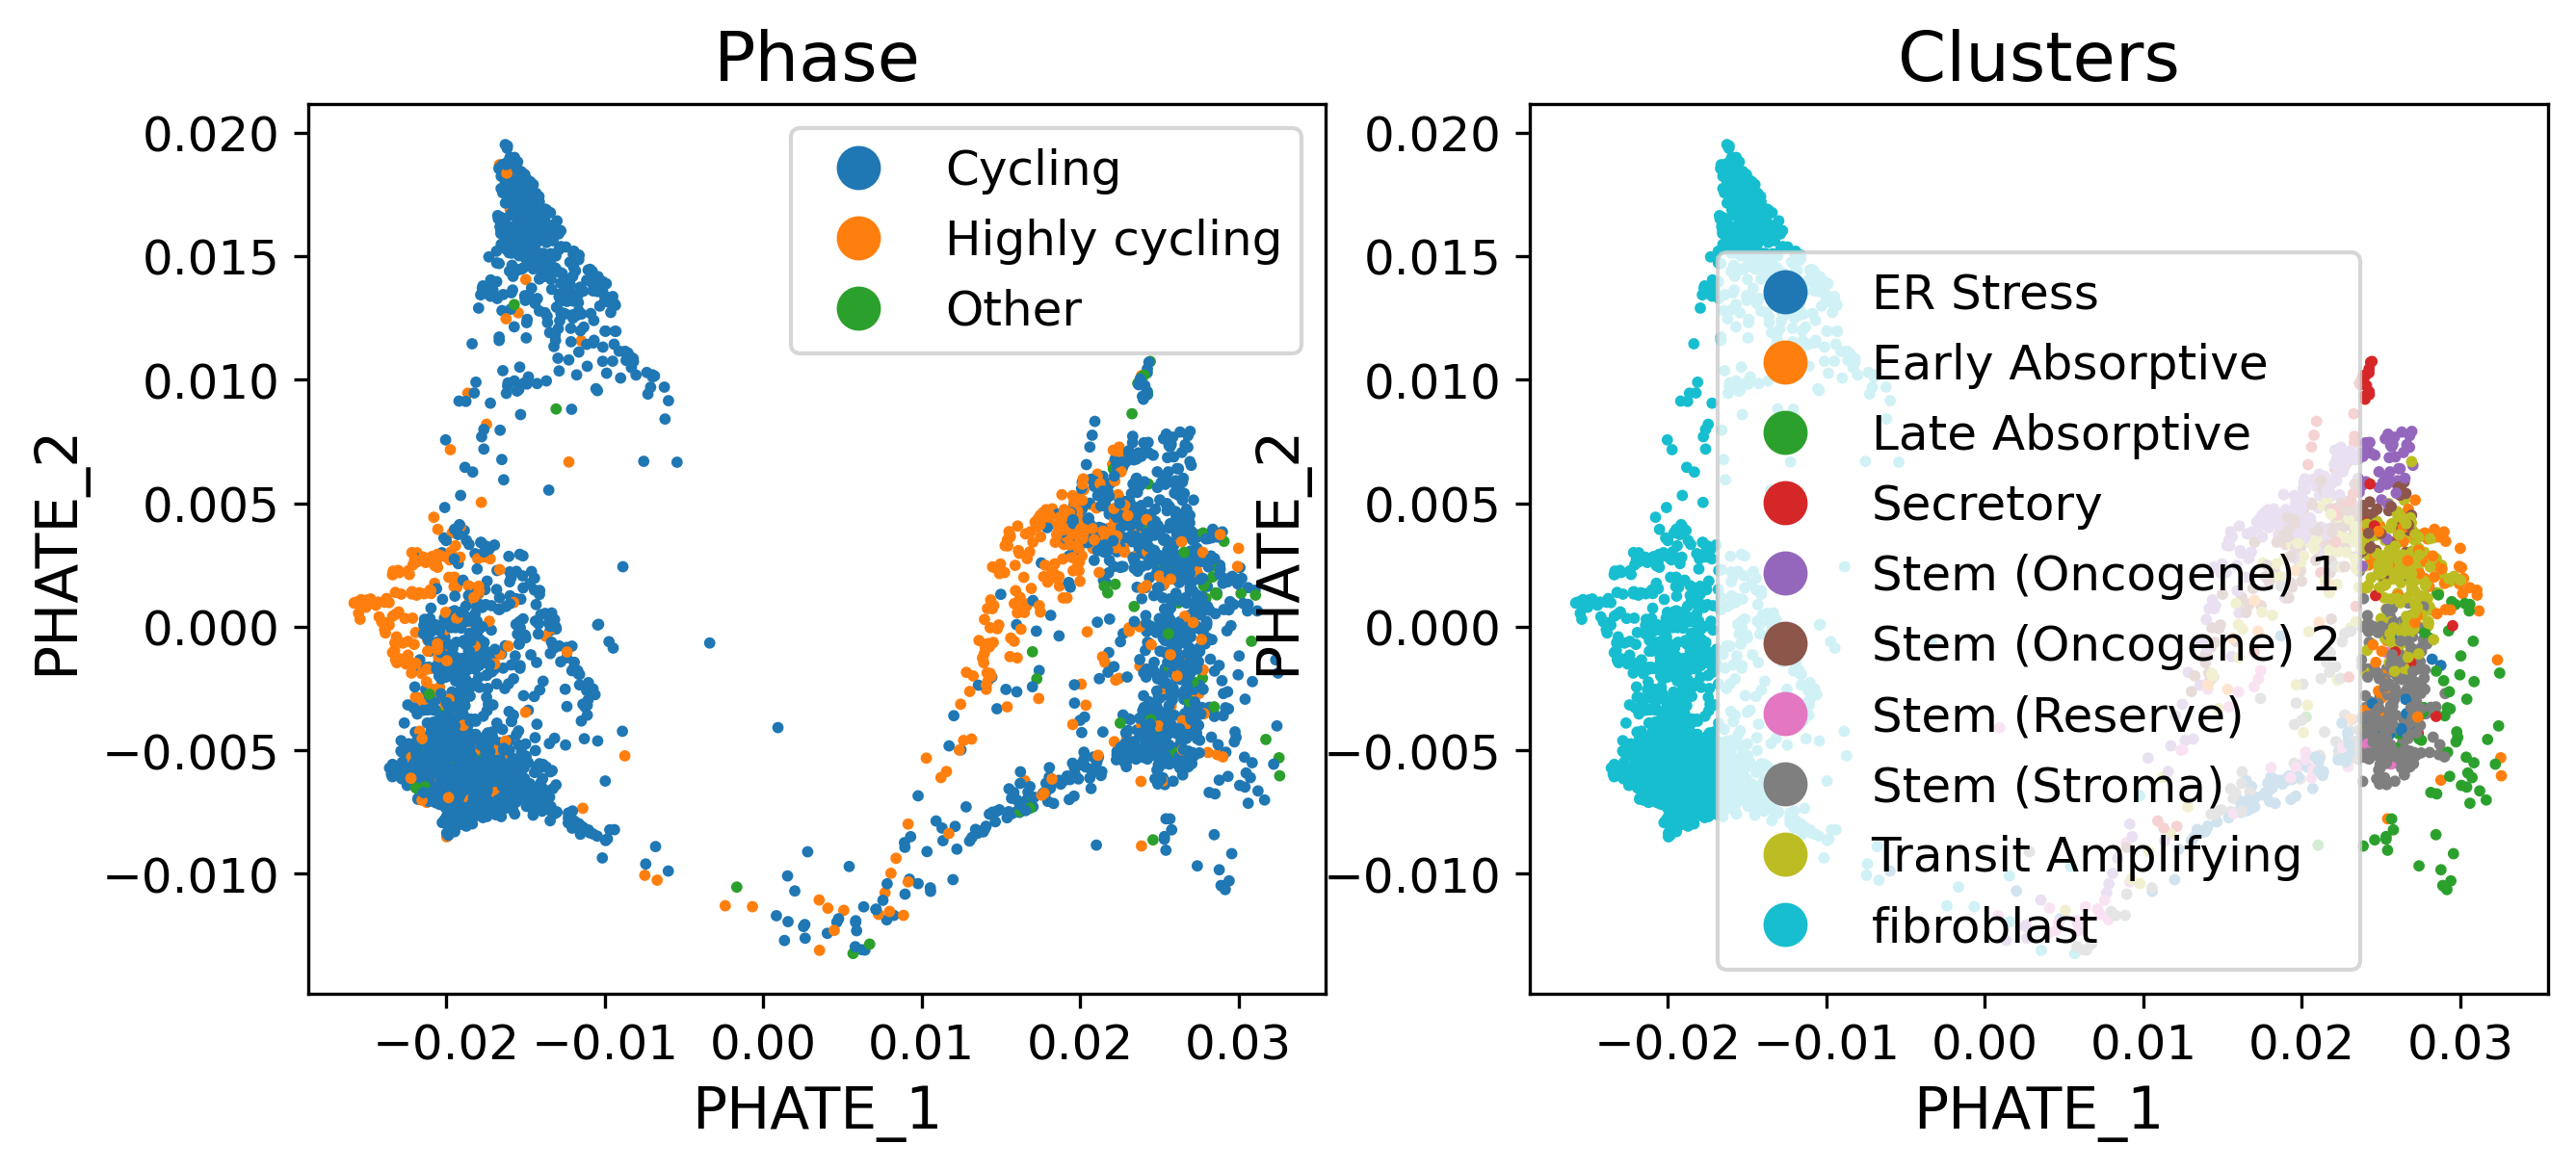

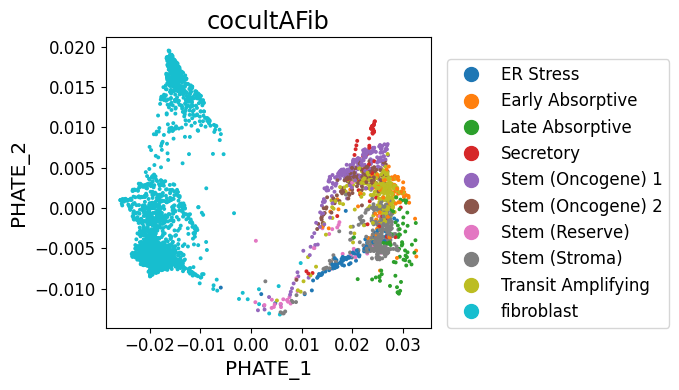

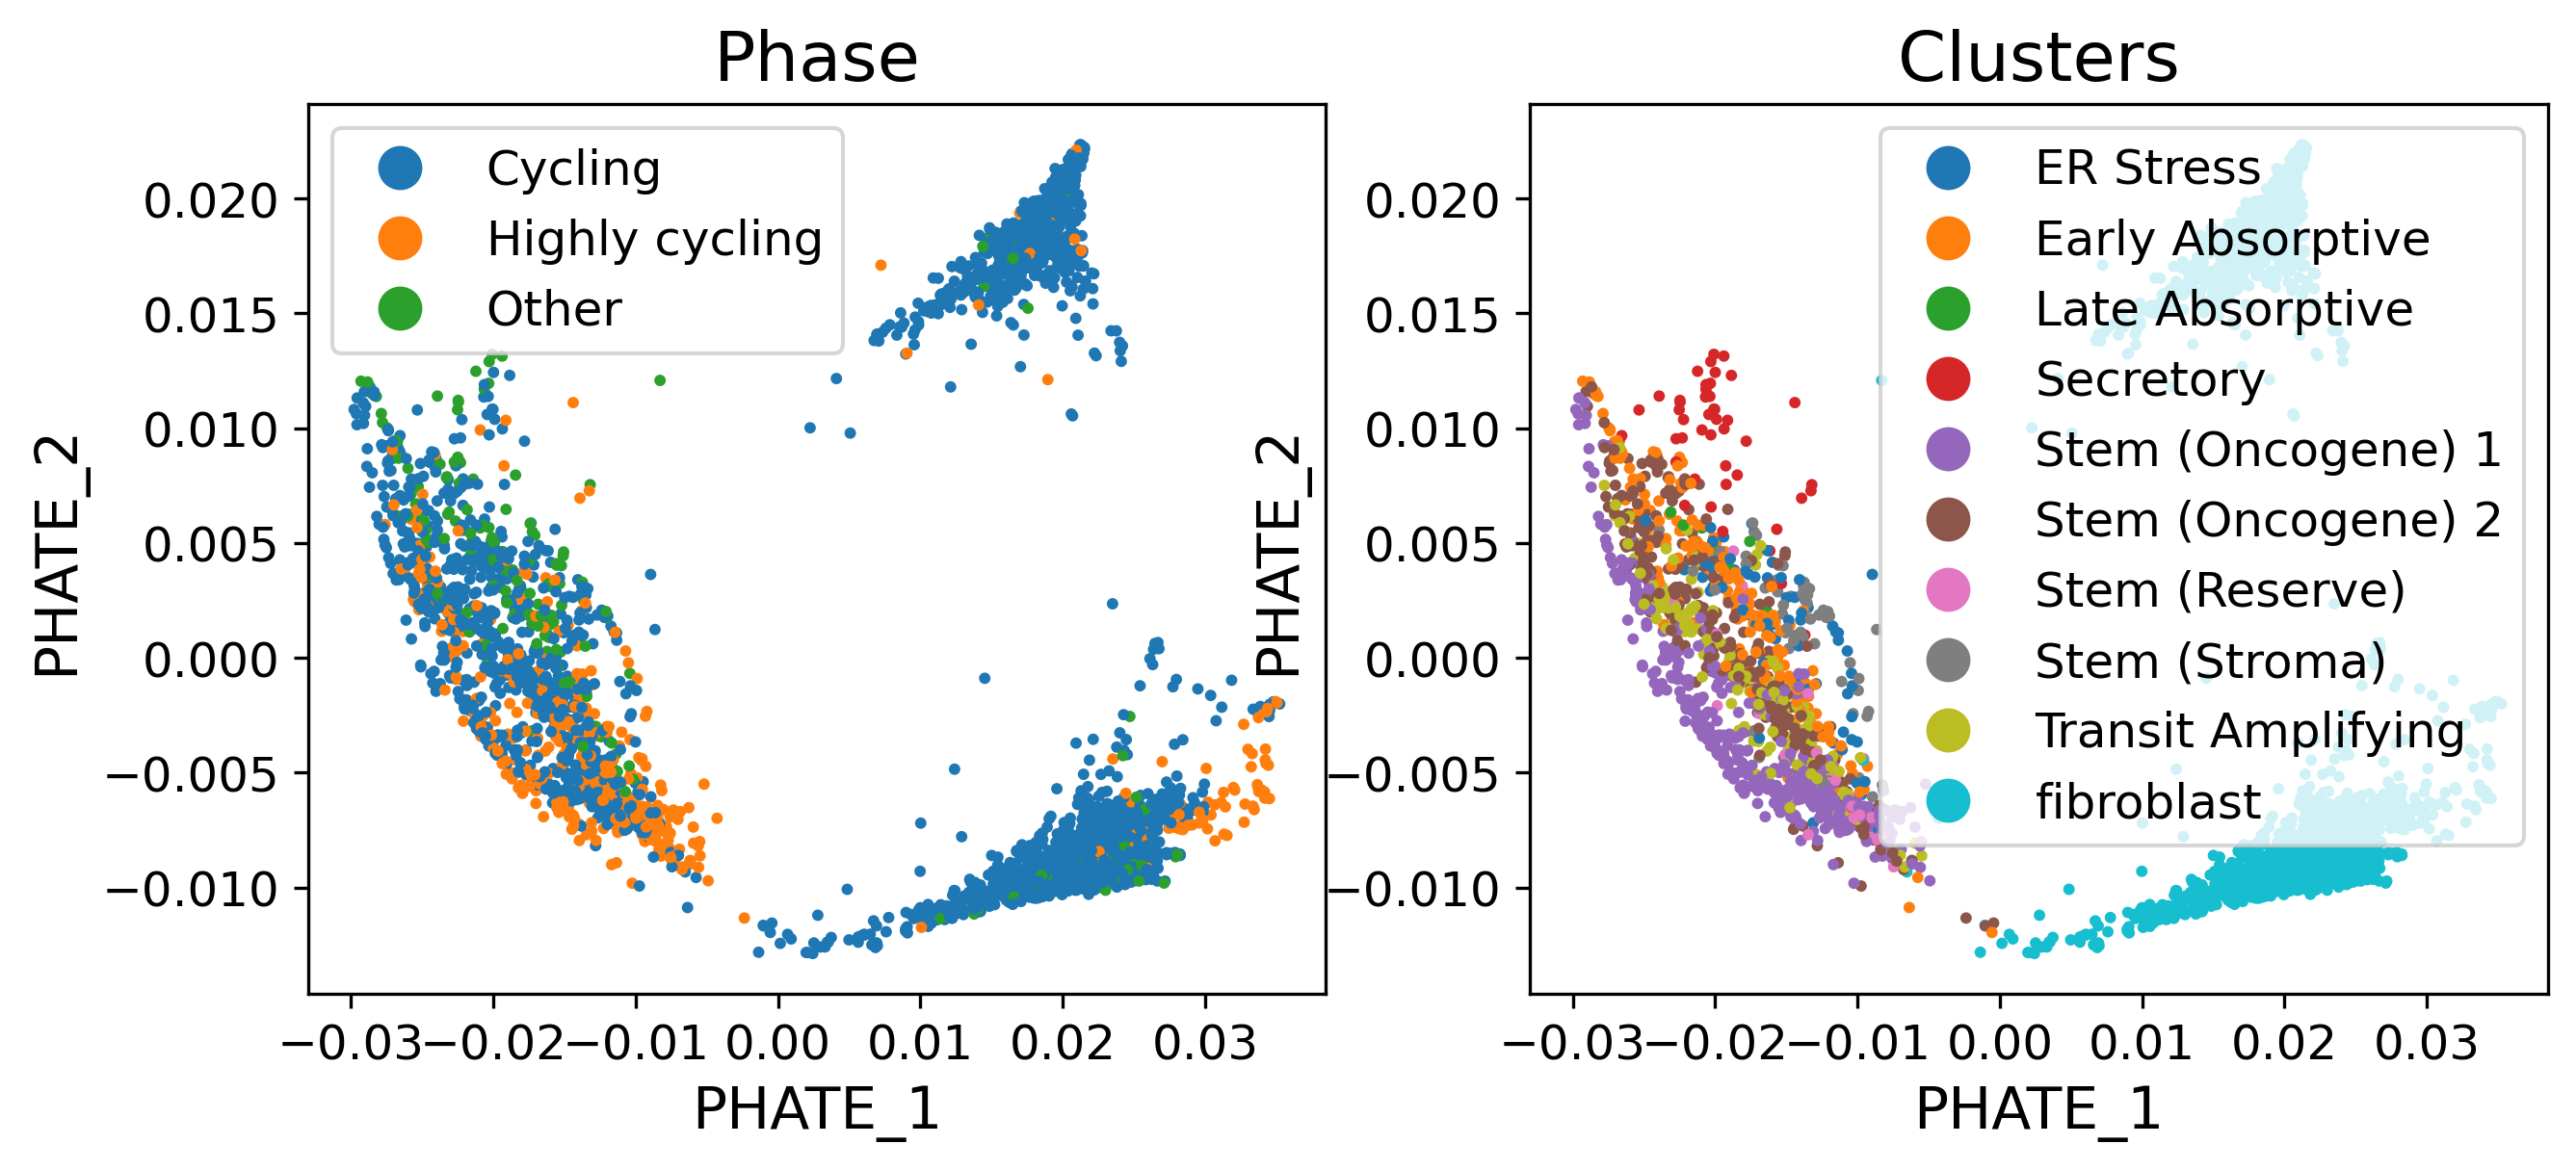

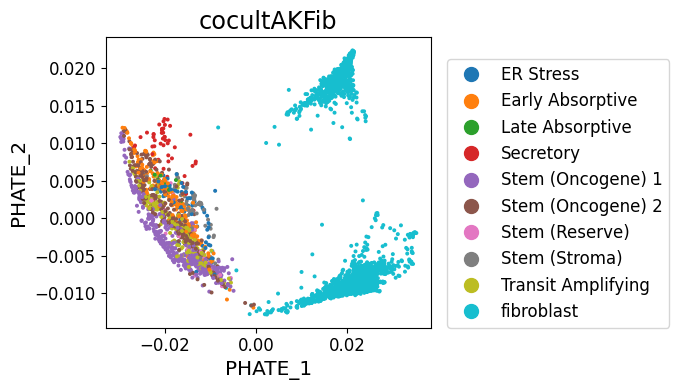

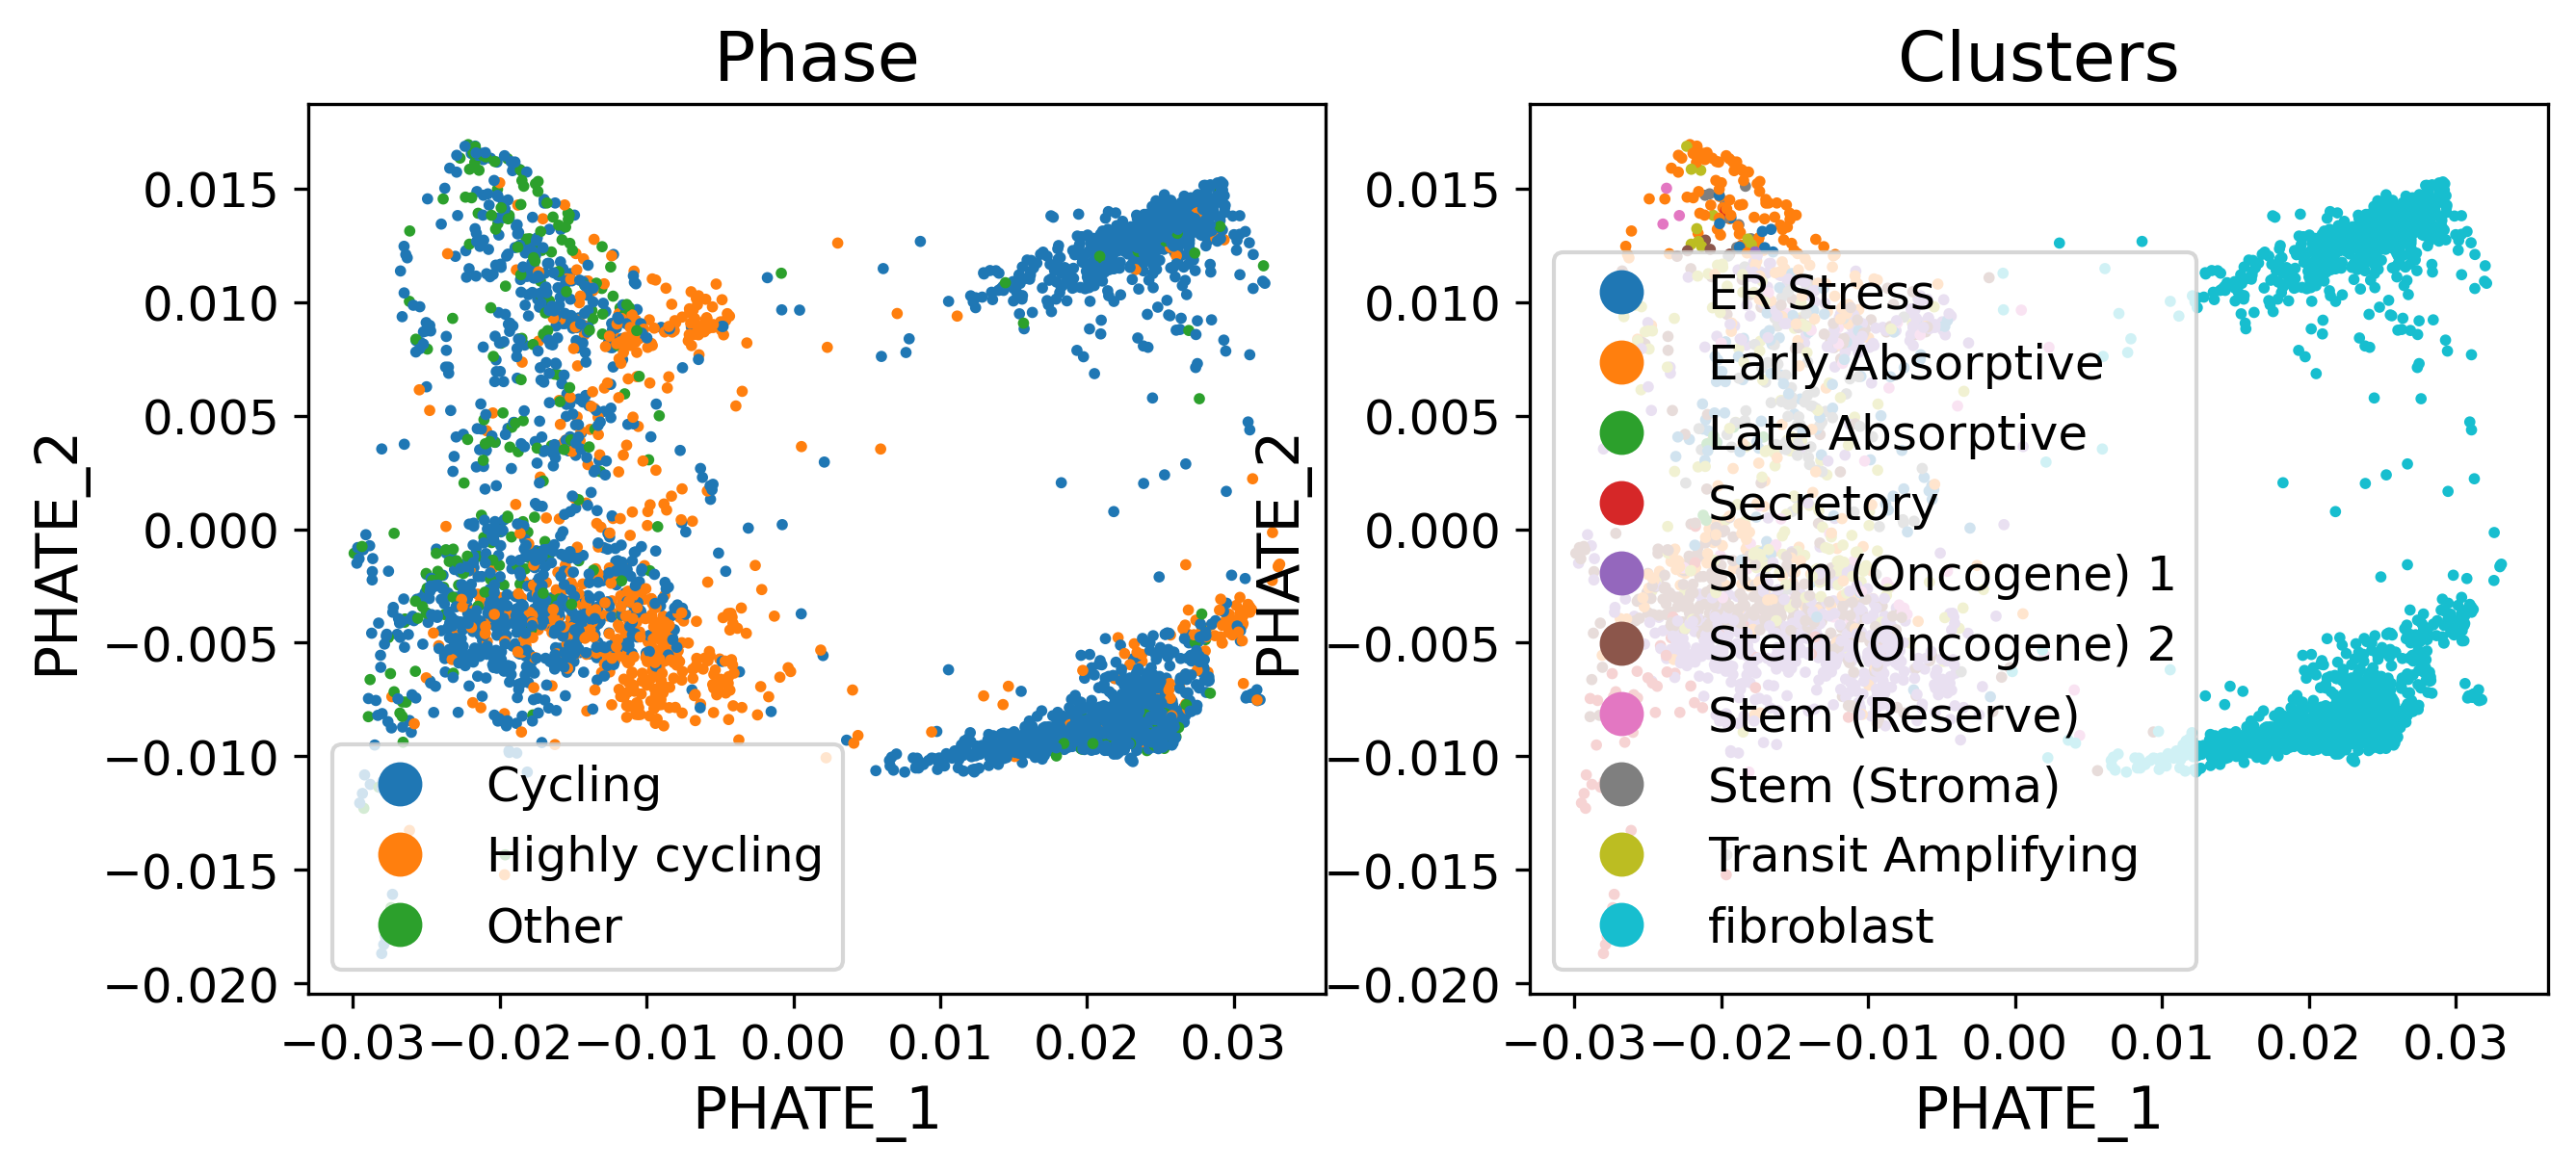

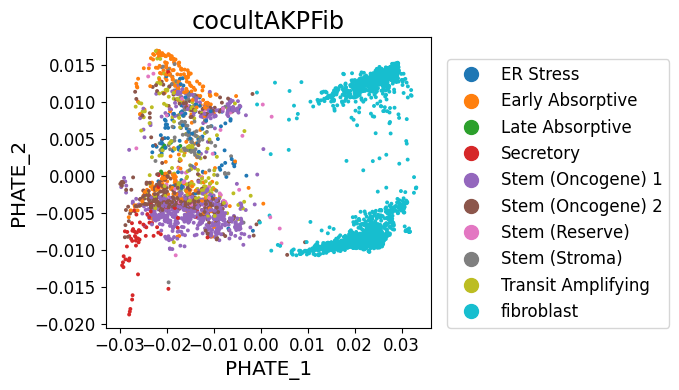

In [11]:
for i in range(len(list_RnaSeq)):
    print(list_RnaSeq[i].obsm)#No DimRed were ported over
    #Add phate dims and view
    list_RnaSeq[i].obsm["X_PHATE"] = list_PHATEcoord[i]

    fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=300); ax=ax.flatten()
    scprep.plot.scatter2d(list_RnaSeq[i].obsm["X_PHATE"], c=list_RnaSeq[i].obs.Phase, figsize=(4.8,3),
        title=f"Phase", ax=ax[0])
    scprep.plot.scatter2d(list_RnaSeq[i].obsm["X_PHATE"], c=list_RnaSeq[i].obs.finalPOPS, figsize=(4.8,3),
        title=f"Clusters", ax=ax[1])

    scprep.plot.scatter2d(
        list_RnaSeq[i].obsm["X_PHATE"], 
        c=list_RnaSeq[i].obs.finalPOPS, 
        title=list_RnaSeq[i].obs["orig.ident"][0], 
        legend_loc=(1.05, 0), shuffle=True,
        figsize=(7,4), dpi=480)

    print(f"Before filtering the object we have {len(list_RnaSeq[i].var_names)} genes")
    scanpy.pp.filter_genes(list_RnaSeq[i], min_cells=4, inplace=True)
    print(f"After filtering genes expressed in fewer than 4 cells we have {len(list_RnaSeq[i].var_names)}")


In [12]:
#Generate concatenated logcount and MD dataframes
dRnaSeq = pd.concat([
    list_RnaSeq[0].to_df(layer="logcounts"),
    list_RnaSeq[1].to_df(layer="logcounts"),
    list_RnaSeq[2].to_df(layer="logcounts"),
    list_RnaSeq[3].to_df(layer="logcounts")
    ])
dRnaSeq

Gm37363  Gm6123    Mrpl15  Gm37144    Lypla1  \
WT__AAACCCACAGCTTCCT-1       0.0     0.0  0.000000      0.0  0.000000   
WT__AAACCCAGTTCGAGCC-1       0.0     0.0  0.000000      0.0  0.000000   
WT__AAACGAAAGAAGGATG-1       0.0     0.0  0.000000      0.0  0.000000   
WT__AAACGAAAGGAAAGGT-1       0.0     0.0  0.000000      0.0  0.000000   
WT__AAACGAAAGTTAACGA-1       0.0     0.0  1.006380      0.0  0.000000   
...                          ...     ...       ...      ...       ...   
AKP__TTTGTTGAGGTATTGA-1      NaN     0.0  0.551146      0.0  0.000000   
AKP__TTTGTTGCAGAACATA-1      NaN     0.0  0.878202      0.0  0.532558   
AKP__TTTGTTGGTCGCATTA-1      NaN     0.0  1.187719      0.0  0.451011   
AKP__TTTGTTGGTGTCTTCC-1      NaN     0.0  1.177853      0.0  0.000000   
AKP__TTTGTTGTCAAGGAGC-1      NaN     0.0  0.581945      0.0  0.000000   

                         Gm37988     Tcea1  Rgs20   Atp6v1h    Rb1cc1  ...  \
WT__AAACCCACAGCTTCCT-1       0.0  1.050319    0.0  0.000000  0.000000  ...   
WT__AAACCCAGTTCGAGCC-1       0.0  0.829238    0.0  0.498218  0.000000  ...   
WT__AAACGAAAGAAGGATG-1       0.0  0.000000    0.0  0.469502  0.469502  ...   
WT__AAACGAAAGGAAAGGT-1       0.0  0.000000    0.0  0.000000  0.000000  ...   
WT__AAACGAAAGTTAACGA-1       0.0  0.402734    0.0  0.402734  0.221506  ...   
...                          ...       ...    ...       ...       ...  ...   
AKP__TTTGTTGAGGTATTGA-1      0.0  0.904413    0.0  0.000000  1.164937  ...   
AKP__TTTGTTGCAGAACATA-1      0.0  0.000000    0.0  0.532558  0.532558  ...   
AKP__TTTGTTGGTCGCATTA-1      0.0  0.000000    0.0  0.996836  0.000000  ...   
AKP__TTTGTTGGTGTCTTCC-1      0.0  0.853749    0.0  0.371204  0.000000  ...   
AKP__TTTGTTGTCAAGGAGC-1      0.0  0.000000    0.0  0.000000  0.947414  ...   

                         Gm16066  Gm50131  Gm32256  Gm50255  Gm5822  \
WT__AAACCCACAGCTTCCT-1       NaN      NaN      NaN      NaN     NaN   
WT__AAACCCAGTTCGAGCC-1       NaN      NaN      NaN      NaN     NaN   
WT__AAACGAAAGAAGGATG-1       NaN      NaN      NaN      NaN     NaN   
WT__AAACGAAAGGAAAGGT-1       NaN      NaN      NaN      NaN     NaN   
WT__AAACGAAAGTTAACGA-1       NaN      NaN      NaN      NaN     NaN   
...                          ...      ...      ...      ...     ...   
AKP__TTTGTTGAGGTATTGA-1      0.0      0.0      0.0      0.0     0.0   
AKP__TTTGTTGCAGAACATA-1      0.0      0.0      0.0      0.0     0.0   
AKP__TTTGTTGGTCGCATTA-1      0.0      0.0      0.0      0.0     0.0   
AKP__TTTGTTGGTGTCTTCC-1      0.0      0.0      0.0      0.0     0.0   
AKP__TTTGTTGTCAAGGAGC-1      0.0      0.0      0.0      0.0     0.0   

                         4933411K16Rik  Elovl3  Gm26158  mt-Tn  mt-Td  
WT__AAACCCACAGCTTCCT-1             NaN     NaN      NaN    NaN    NaN  
WT__AAACCCAGTTCGAGCC-1             NaN     NaN      NaN    NaN    NaN  
WT__AAACGAAAGAAGGATG-1             NaN     NaN      NaN    NaN    NaN  
WT__AAACGAAAGGAAAGGT-1             NaN     NaN      NaN    NaN    NaN  
WT__AAACGAAAGTTAACGA-1             NaN     NaN      NaN    NaN    NaN  
...                                ...     ...      ...    ...    ...  
AKP__TTTGTTGAGGTATTGA-1            0.0     0.0      0.0    0.0    0.0  
AKP__TTTGTTGCAGAACATA-1            0.0     0.0      0.0    0.0    0.0  
AKP__TTTGTTGGTCGCATTA-1            0.0     0.0      0.0    0.0    0.0  
AKP__TTTGTTGGTGTCTTCC-1            0.0     0.0      0.0    0.0    0.0  
AKP__TTTGTTGTCAAGGAGC-1            0.0     0.0      0.0    0.0    0.0  

[14546 rows x 22444 columns]

In [13]:
dSEQmd = pd.concat([
    list_RnaSeq[0].obs,
    list_RnaSeq[1].obs,
    list_RnaSeq[2].obs,
    list_RnaSeq[3].obs
    ])
dSEQmd

orig.ident  nCount_RNA  nFeature_RNA  mito_content  \
WT__AAACCCACAGCTTCCT-1    cocultWTFib     10761.0          3163      0.947867   
WT__AAACCCAGTTCGAGCC-1    cocultWTFib     15485.0          3811      1.233452   
WT__AAACGAAAGAAGGATG-1    cocultWTFib     16689.0          3775      1.270298   
WT__AAACGAAAGGAAAGGT-1    cocultWTFib      5756.0          2126      1.476720   
WT__AAACGAAAGTTAACGA-1    cocultWTFib     40330.0          4714      0.451277   
...                               ...         ...           ...           ...   
AKP__TTTGTTGAGGTATTGA-1  cocultAKPFib     13601.0          3501      1.426366   
AKP__TTTGTTGCAGAACATA-1  cocultAKPFib     14219.0          3653      0.914270   
AKP__TTTGTTGGTCGCATTA-1  cocultAKPFib     17547.0          3948      0.569898   
AKP__TTTGTTGGTGTCTTCC-1  cocultAKPFib     22248.0          4367      0.651744   
AKP__TTTGTTGTCAAGGAGC-1  cocultAKPFib     12666.0          3940      1.444813   

                         rfp_content  gfp_content  nCount_SCT  nFeature_SCT  \
WT__AAACCCACAGCTTCCT-1      0.009293     0.000000     17183.0          3206   
WT__AAACCCAGTTCGAGCC-1      0.000000     0.000000     17347.0          3811   
WT__AAACGAAAGAAGGATG-1      0.000000     0.000000     17508.0          3775   
WT__AAACGAAAGGAAAGGT-1      0.000000     0.000000     16159.0          2915   
WT__AAACGAAAGTTAACGA-1      0.000000     0.000000     18645.0          3719   
...                              ...          ...         ...           ...   
AKP__TTTGTTGAGGTATTGA-1     0.007352     0.000000     17257.0          3502   
AKP__TTTGTTGCAGAACATA-1     0.000000     0.000000     17230.0          3654   
AKP__TTTGTTGGTCGCATTA-1     0.000000     0.222260     17780.0          3948   
AKP__TTTGTTGGTGTCTTCC-1     0.000000     0.125854     18580.0          4365   
AKP__TTTGTTGTCAAGGAGC-1     0.007895     0.000000     16943.0          3947   

                          S.Score  G2M.Score           Phase     old.ident  \
WT__AAACCCACAGCTTCCT-1   0.091728  -0.035993         Cycling   cocultWTFib   
WT__AAACCCAGTTCGAGCC-1   0.047732  -0.003214         Cycling   cocultWTFib   
WT__AAACGAAAGAAGGATG-1   0.048829  -0.047012         Cycling   cocultWTFib   
WT__AAACGAAAGGAAAGGT-1   0.042995  -0.003853         Cycling   cocultWTFib   
WT__AAACGAAAGTTAACGA-1   0.011989  -0.003207         Cycling   cocultWTFib   
...                           ...        ...             ...           ...   
AKP__TTTGTTGAGGTATTGA-1  0.049953  -0.017999         Cycling  cocultAKPFib   
AKP__TTTGTTGCAGAACATA-1  0.057069  -0.000151         Cycling  cocultAKPFib   
AKP__TTTGTTGGTCGCATTA-1 -0.012032  -0.064251           Other  cocultAKPFib   
AKP__TTTGTTGGTGTCTTCC-1  0.138434   0.286674  Highly cycling  cocultAKPFib   
AKP__TTTGTTGTCAAGGAGC-1 -0.002047  -0.024835           Other  cocultAKPFib   

                           CCDiff SCT_snn_res.0.6 seurat_clusters  \
WT__AAACCCACAGCTTCCT-1   0.127722               4               4   
WT__AAACCCAGTTCGAGCC-1   0.050946               2               2   
WT__AAACGAAAGAAGGATG-1   0.095840               2               2   
WT__AAACGAAAGGAAAGGT-1   0.046847               9               9   
WT__AAACGAAAGTTAACGA-1   0.015196               5               5   
...                           ...             ...             ...   
AKP__TTTGTTGAGGTATTGA-1  0.067951               6               6   
AKP__TTTGTTGCAGAACATA-1  0.057220               1               1   
AKP__TTTGTTGGTCGCATTA-1  0.052219               5               5   
AKP__TTTGTTGGTGTCTTCC-1 -0.148240               3               3   
AKP__TTTGTTGTCAAGGAGC-1  0.022788               2               2   

                               curatedCLUST    old.clust           finalPOPS  \
WT__AAACCCACAGCTTCCT-1                  NaN   fibroblast          fibroblast   
WT__AAACCCAGTTCGAGCC-1                  NaN   fibroblast          fibroblast   
WT__AAACGAAAGAAGGATG-1                  NaN   fibroblast          fibroblast   
WT__AAACGAAAGGAAAGG

In [14]:
#Rmv unnecessary objects
del list_RnaSeq,list_PHATEcoord

### Process data to human

Convert SEQ data to HGNC symbols

In [15]:
from biomart import BiomartServer

mart = BiomartServer("http://useast.ensembl.org/biomart").datasets["mmusculus_gene_ensembl"]
# mart.show_attributes()
# for i in mart.show_attributes_by_page():
#     print(i)

response = mart.search({"attributes":["external_gene_name",
            "hsapiens_homolog_associated_gene_name"]})

mouse2human = []
for line in response.raw.data.decode("utf-8").splitlines():
    line = line.split("\t")
    if len(line[0]) > 0: #Only get gene symbols with ENSP ID
        mouse2human.append(line)
mouse2human = pd.DataFrame(mouse2human, 
                columns=["mgi_symbol","hgnc_symbol"]
                ).drop_duplicates() 
mouse2human = mouse2human.set_index("mgi_symbol"
                ).to_dict(
                    #Transform DF into a dictionary but first set index
                )["hgnc_symbol"]#Nested dict, so get first (and only item)


In [16]:
dRnaSeq = dRnaSeq.rename(columns=mouse2human).drop(
            columns=[""])
#After conversion some columns get duplicated. Group by them and average their gene expression
dRnaSeq = dRnaSeq.groupby(by=dRnaSeq.columns, axis=1).mean() 
dRnaSeq

0610010F05Rik  1110008P14Rik  1110012L19Rik  \
WT__AAACCCACAGCTTCCT-1             0.0       1.050319       0.000000   
WT__AAACCCAGTTCGAGCC-1             0.0       0.498218       0.000000   
WT__AAACGAAAGAAGGATG-1             0.0       1.222830       0.000000   
WT__AAACGAAAGGAAAGGT-1             0.0       1.006978       0.000000   
WT__AAACGAAAGTTAACGA-1             0.0       1.497693       0.000000   
...                                ...            ...            ...   
AKP__TTTGTTGAGGTATTGA-1            0.0       0.904413       0.000000   
AKP__TTTGTTGCAGAACATA-1            0.0       0.532558       0.000000   
AKP__TTTGTTGGTCGCATTA-1            0.0       0.996836       0.000000   
AKP__TTTGTTGGTGTCTTCC-1            0.0       1.177853       0.000000   
AKP__TTTGTTGTCAAGGAGC-1            0.0       0.947414       0.581945   

                         1300017J02Rik  1500009C09Rik  1700015F17Rik  \
WT__AAACCCACAGCTTCCT-1             0.0            0.0            0.0   
WT__AAACCCAGTTCGAGCC-1             0.0            0.0            0.0   
WT__AAACGAAAGAAGGATG-1             0.0            0.0            0.0   
WT__AAACGAAAGGAAAGGT-1             0.0            0.0            0.0   
WT__AAACGAAAGTTAACGA-1             0.0            0.0            0.0   
...                                ...            ...            ...   
AKP__TTTGTTGAGGTATTGA-1            0.0            NaN            0.0   
AKP__TTTGTTGCAGAACATA-1            0.0            NaN            0.0   
AKP__TTTGTTGGTCGCATTA-1            0.0            NaN            0.0   
AKP__TTTGTTGGTGTCTTCC-1            0.0            NaN            0.0   
AKP__TTTGTTGTCAAGGAGC-1            0.0            NaN            0.0   

                         1700020D05Rik  1700030C10Rik.1  1810026B05Rik  \
WT__AAACCCACAGCTTCCT-1             0.0              0.0       0.657148   
WT__AAACCCAGTTCGAGCC-1             0.0              0.0       0.498218   
WT__AAACGAAAGAAGGATG-1             0.0              0.0       0.787727   
WT__AAACGAAAGGAAAGGT-1             0.0              0.0       0.000000   
WT__AAACGAAAGTTAACGA-1             0.0              0.0       0.402734   
...                                ...              ...            ...   
AKP__TTTGTTGAGGTATTGA-1            0.0              NaN       0.551146   
AKP__TTTGTTGCAGAACATA-1            0.0              NaN       0.878202   
AKP__TTTGTTGGTCGCATTA-1            0.0              NaN       0.000000   
AKP__TTTGTTGGTGTCTTCC-1            0.0              NaN       0.371204   
AKP__TTTGTTGTCAAGGAGC-1            0.0              NaN       1.214481   

                         2010300C02Rik  ...       ZYX     ZZEF1      ZZZ3  \
WT__AAACCCACAGCTTCCT-1             0.0  ...  0.657148  0.657148  0.657148   
WT__AAACCCAGTTCGAGCC-1             0.0  ...  0.498218  0.000000  0.829238   
WT__AAACGAAAGAAGGATG-1             0.0  ...  1.028759  0.000000  0.000000   
WT__AAACGAAAGGAAAGGT-1             0.0  ...  0.000000  0.000000  0.000000   
WT__AAACGAAAGTTAACGA-1             0.0  ...  0.000000  0.221506  0.000000   
...                                ...  ...       ...       ...       ...   
AKP__TTTGTTGAGGTATTGA-1            0.0  ...  0.904413  0.000000  0.000000   
AKP__TTTGTTGCAGAACATA-1            0.0  ...  0.000000  0.532558  0.000000   
AKP__TTTGTTGGTCGCATTA-1            0.0  ...  0.451011  0.000000  0.000000   
AKP__TTTGTTGGTGTCTTCC-1            0.0  ...  0.000000  0.641305  0.000000   
AKP__TTTGTTGTCAAGGAGC-1            0.0  ...  0.947414  0.581945  0.000000   

                          Zfp91.1  Zkscan7.1     Znrd1   Znrd1as  n-R5-8s1  \
WT__AAACCCACAGCTTCCT-1   0.000000        0.0  1.050319  0.657148       0.0   
WT__AAACCCAGTTCGAGCC-1   0.000000        0.0  1.077511  0.000000       0.0   
WT__AAACGAAAGAAGGATG-1   0.000000        0.0  0.000000  0.000000       0.0   
WT__AAACGAAAGGAAAGGT-1   1.006978        0.0  0.000000  0.000000       0.0   
WT__AAACGAAAGTTAACGA-1   0.221506        0.0  0.556103  0.221506       0.0   
...          

In [17]:
from sklearn.impute import SimpleImputer

dRnaSeq = pd.DataFrame(
    data=SimpleImputer(strategy="constant").fit_transform(dRnaSeq),
    index=dRnaSeq.index, columns=dRnaSeq.columns)

dRnaSeq

0610010F05Rik  1110008P14Rik  1110012L19Rik  \
WT__AAACCCACAGCTTCCT-1             0.0       1.050319       0.000000   
WT__AAACCCAGTTCGAGCC-1             0.0       0.498218       0.000000   
WT__AAACGAAAGAAGGATG-1             0.0       1.222830       0.000000   
WT__AAACGAAAGGAAAGGT-1             0.0       1.006978       0.000000   
WT__AAACGAAAGTTAACGA-1             0.0       1.497693       0.000000   
...                                ...            ...            ...   
AKP__TTTGTTGAGGTATTGA-1            0.0       0.904413       0.000000   
AKP__TTTGTTGCAGAACATA-1            0.0       0.532558       0.000000   
AKP__TTTGTTGGTCGCATTA-1            0.0       0.996836       0.000000   
AKP__TTTGTTGGTGTCTTCC-1            0.0       1.177853       0.000000   
AKP__TTTGTTGTCAAGGAGC-1            0.0       0.947414       0.581945   

                         1300017J02Rik  1500009C09Rik  1700015F17Rik  \
WT__AAACCCACAGCTTCCT-1             0.0            0.0            0.0   
WT__AAACCCAGTTCGAGCC-1             0.0            0.0            0.0   
WT__AAACGAAAGAAGGATG-1             0.0            0.0            0.0   
WT__AAACGAAAGGAAAGGT-1             0.0            0.0            0.0   
WT__AAACGAAAGTTAACGA-1             0.0            0.0            0.0   
...                                ...            ...            ...   
AKP__TTTGTTGAGGTATTGA-1            0.0            0.0            0.0   
AKP__TTTGTTGCAGAACATA-1            0.0            0.0            0.0   
AKP__TTTGTTGGTCGCATTA-1            0.0            0.0            0.0   
AKP__TTTGTTGGTGTCTTCC-1            0.0            0.0            0.0   
AKP__TTTGTTGTCAAGGAGC-1            0.0            0.0            0.0   

                         1700020D05Rik  1700030C10Rik.1  1810026B05Rik  \
WT__AAACCCACAGCTTCCT-1             0.0              0.0       0.657148   
WT__AAACCCAGTTCGAGCC-1             0.0              0.0       0.498218   
WT__AAACGAAAGAAGGATG-1             0.0              0.0       0.787727   
WT__AAACGAAAGGAAAGGT-1             0.0              0.0       0.000000   
WT__AAACGAAAGTTAACGA-1             0.0              0.0       0.402734   
...                                ...              ...            ...   
AKP__TTTGTTGAGGTATTGA-1            0.0              0.0       0.551146   
AKP__TTTGTTGCAGAACATA-1            0.0              0.0       0.878202   
AKP__TTTGTTGGTCGCATTA-1            0.0              0.0       0.000000   
AKP__TTTGTTGGTGTCTTCC-1            0.0              0.0       0.371204   
AKP__TTTGTTGTCAAGGAGC-1            0.0              0.0       1.214481   

                         2010300C02Rik  ...       ZYX     ZZEF1      ZZZ3  \
WT__AAACCCACAGCTTCCT-1             0.0  ...  0.657148  0.657148  0.657148   
WT__AAACCCAGTTCGAGCC-1             0.0  ...  0.498218  0.000000  0.829238   
WT__AAACGAAAGAAGGATG-1             0.0  ...  1.028759  0.000000  0.000000   
WT__AAACGAAAGGAAAGGT-1             0.0  ...  0.000000  0.000000  0.000000   
WT__AAACGAAAGTTAACGA-1             0.0  ...  0.000000  0.221506  0.000000   
...                                ...  ...       ...       ...       ...   
AKP__TTTGTTGAGGTATTGA-1            0.0  ...  0.904413  0.000000  0.000000   
AKP__TTTGTTGCAGAACATA-1            0.0  ...  0.000000  0.532558  0.000000   
AKP__TTTGTTGGTCGCATTA-1            0.0  ...  0.451011  0.000000  0.000000   
AKP__TTTGTTGGTGTCTTCC-1            0.0  ...  0.000000  0.641305  0.000000   
AKP__TTTGTTGTCAAGGAGC-1            0.0  ...  0.947414  0.581945  0.000000   

                          Zfp91.1  Zkscan7.1     Znrd1   Znrd1as  n-R5-8s1  \
WT__AAACCCACAGCTTCCT-1   0.000000        0.0  1.050319  0.657148       0.0   
WT__AAACCCAGTTCGAGCC-1   0.000000        0.0  1.077511  0.000000       0.0   
WT__AAACGAAAGAAGGATG-1   0.000000        0.0  0.000000  0.000000       0.0   
WT__AAACGAAAGGAAAGGT-1   1.006978        0.0  0.000000  0.000000       0.0   
WT__AAACGAAAGTTAACGA-1   0.221506        0.0  0.556103  0.221506       0.0   
...          

## Load KG data

In [18]:
dKGnn = pd.read_csv(f"{data_dir}/dKGnn.csv.tar.gz", header=None)
dKGnn

0        1        2
0                CXCL1       LR    CXCR2
1                CXCL2       LR    CXCR2
2                CXCL3       LR    CXCR2
3                CXCL5       LR    CXCR2
4                 PPBP       LR    CXCR2
...                ...      ...      ...
5444497  R-HSA-6798695  pathway  SIGLEC5
5444498  R-HSA-1181150  pathway  TDGF1P3
5444499  R-HSA-1433617  pathway  TDGF1P3
5444500  R-HSA-3295583  pathway    TRPM5
5444501  R-HSA-9717207  pathway    TRPM5

[5444502 rows x 3 columns]

In [19]:
modelKGE = "KGnn_50_unstratified_stopped_transe"

try:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl")
except RuntimeError:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl",
    map_location=torch.device("cpu"))

#Construct nodes dataframe: detach() for now is meaningless as compute is CPU
entity_embeddings = trained_model.entity_representations[0](indices=None).detach().cpu().numpy()
import json
with open(f"{data_dir}/dKGnn_entityIDS.json") as infile:
    entityIDS = json.load(infile)
dKGEnn_50 = pd.DataFrame(entity_embeddings, index=entityIDS.values()).drop(index=["nan"])
dKGEnn_50

0         1         2         3         4         5   \
A1BG     -0.114693 -0.062056 -0.142618 -0.018786  0.079787  0.151638   
A1BG-AS1  0.124340 -0.244321  0.261028  0.177759  0.052111 -0.206777   
A1CF      0.012249  0.097411  0.089748 -0.107028  0.042079 -0.015802   
A2M      -0.076020  0.167864 -0.133910 -0.082698  0.086467 -0.096204   
A2M-AS1  -0.124042 -0.071744  0.190024  0.210376 -0.199619 -0.146263   
...            ...       ...       ...       ...       ...       ...   
ZYG11A    0.157768  0.169630  0.128678 -0.037648  0.034921  0.087765   
ZYG11B    0.154281  0.013954 -0.161645 -0.170701  0.077110  0.007194   
ZYX       0.168261  0.047865 -0.021720 -0.076904 -0.110663  0.096434   
ZZEF1    -0.587509  0.074710 -0.146124  0.098394 -0.006699  0.052911   
ZZZ3      0.082273 -0.122881 -0.079879 -0.102180  0.182568 -0.098044   

                6         7         8         9   ...        40        41  \
A1BG      0.154332 -0.166625 -0.164315  0.150550  ...  0.110171  0.162007   
A1BG-AS1 -0.068553  0.004152 -0.151796  0.048616  ...  0.026584 -0.064389   
A1CF     -0.015080 -0.035531 -0.108423  0.396735  ...  0.109560 -0.146671   
A2M      -0.068033 -0.012295 -0.197465 -0.067780  ...  0.217745  0.121485   
A2M-AS1  -0.201290 -0.032545 -0.092695  0.039749  ... -0.011503  0.263200   
...            ...       ...       ...       ...  ...       ...       ...   
ZYG11A   -0.117535 -0.170905  0.005733  0.032774  ...  0.107611  0.173982   
ZYG11B    0.163640  0.013357  0.084101 -0.117073  ...  0.051953 -0.137357   
ZYX       0.134658 -0.113244  0.069367  0.069998  ...  0.089988 -0.037320   
ZZEF1    -0.004144 -0.310832  0.171271  0.067289  ... -0.024145  0.191872   
ZZZ3      0.037568  0.169248  0.135375  0.008222  ... -0.317155  0.172255   

                42        43        44        45        46        47  \
A1BG      0.136376  0.098658  0.172536  0.010266 -0.002167  0.260938   
A1BG-AS1  0.186161  0.029930  0.043194 -0.230858  0.020652 -0.079490   
A1CF      0.138407  0.118278 -0.090030 -0.198067 -0.064056  0.112160   
A2M      -0.044373  0.006619  0.188977 -0.075680 -0.122628  0.149013   
A2M-AS1  -0.154127  0.032356 -0.221216 -0.127091 -0.050592 -0.162741   
...            ...       ...       ...       ...       ...       ...   
ZYG11A    0.080564  0.081189 -0.287715 -0.076782 -0.078907 -0.008748   
ZYG11B   -0.201208  0.120000 -0.147011  0.176326 -0.140640  0.019583   
ZYX      -0.318342  0.089743  0.215972  0.183160 -0.249219  0.011088   
ZZEF1     0.026109  0.103047  0.075540  0.109647  0.108737 -0.114406   
ZZZ3     -0.062920 -0.214967 -0.019557  0.112612  0.041938 -0.038473   

                48        49  
A1BG     -0.156283  0.223170  
A1BG-AS1 -0.100852 -0.110040  
A1CF     -0.157560  0.070585  
A2M      -0.203135  0.045033  
A2M-AS1   0.066823  0.046689  
...            ...       ...  
ZYG11A   -0.215508 -0.271883  
ZYG11B   -0.134760 -0.269244  
ZYX       0.176135 -0.244414  
ZZEF1    -0.031095 -0.060478  
ZZZ3      0.204341  0.047962  

[27619 rows x 50 columns]

## Match genes in KG and scRNA-seq

In [20]:
dGenesSeq = list(dRnaSeq.columns)

#We still filter the KG, but can we just not filter it and then nan/0 inpute/inflate the count matrix instead?
dKGnn_filt = dKGnn.loc[dKGnn[0].isin(dGenesSeq) & dKGnn[2].isin(dGenesSeq)]
print(dKGnn.shape,dKGnn_filt.shape)

dKGEnn_50filt = dKGEnn_50.loc[dKGEnn_50.index.isin(dGenesSeq)]
print(dKGEnn_50.shape,dKGEnn_50filt.shape)

(5444502, 3) (3862577, 3)
(27619, 50) (13791, 50)


In [21]:
dRnaSeq_filt = dRnaSeq.loc[:,dRnaSeq.columns.isin(dKGEnn_50filt.index)]
print(len(dRnaSeq_filt.columns))
print(dRnaSeq_filt.columns.nunique())

13791
13791


In [22]:
del dKGnn,dKGEnn_50,dRnaSeq,dGenesSeq

### Explore filtered KGnn

In [23]:
G = networkx.from_pandas_edgelist(dKGnn_filt, source=0,target=2,edge_attr=1)

print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")
print("We have this many isolates: ", 
    networkx.number_of_isolates(G))
print("The graph is connected:",
    networkx.is_connected(G))

if not networkx.is_connected(G):
    print(f"\nWe have {networkx.number_connected_components(G)} connected subgraphs")
    
    Gcomponents = [G.subgraph(c).copy() for c in networkx.connected_components(G)]
    for i,g in enumerate(Gcomponents,start=1):
        print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")

/var/folders/9p/ypn2045x1cxbq9ptcfk4_k7m0000gn/T/ipykernel_66801/440223923.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")


Graph with 13677 nodes and 2964125 edges, with a density of 0.031693964776231334
We have this many isolates:  0
The graph is connected: True


No need to work with any components.NOte however that the number of entities 
does not match the number of nodes in the networkx object.

In [24]:
dKGnn_filt = dKGnn_filt.loc[dKGnn_filt[0].isin(G.nodes()) & dKGnn_filt[2].isin(G.nodes())]
dKGEnn_50filt = dKGEnn_50filt.loc[dKGEnn_50filt.index.isin(G.nodes())]
dRnaSeq_filt = dRnaSeq_filt.loc[:,dRnaSeq_filt.columns.isin(G.nodes())]
print(dKGnn_filt.shape, dKGEnn_50filt.shape, dRnaSeq_filt.shape)

(3862577, 3) (13677, 50) (14546, 13677)


# Process scRNA data

### Normalise and denoise gene expression data

Use MAGIC with all genes to denoise, smooth and inpute missing values.
Then subset to genes present in KG.
Then normalise so that the gene expression distributions are equally big for each cell.

We will compute MAGIC with default knn-related params (and not giving it a precomputed graph) and using all genes. However, with the `genes` argument, one should be able to return a processed matrix with only the genes present in the KG (whil still leveraging allthe full suite of genes in the dataset)

In [25]:
#MAGIC
magic_op = magic.MAGIC(
    knn=5, # knn_max set to 3*knn by default
    knn_dist="euclidean",
    decay=1, t=3, n_pca=100, random_state=12,
    n_jobs=-2 #All but one
                        )

In [26]:
dMagicRnaSeq = magic_op.fit_transform(
    X = dRnaSeq_filt
)
del magic_op
dMagicRnaSeq

Calculating MAGIC...
  Running MAGIC on 14546 cells and 13677 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.97 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.40 seconds.
    Calculating affinities...
    Calculated affinities in 2.36 seconds.
  Calculated graph and diffusion operator in 10.32 seconds.
  Running MAGIC with `solver='exact'` on 13677-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 10.65 seconds.
Calculated MAGIC in 21.28 seconds.


A1CF   A3GALT2    A4GALT     A4GNT      AAAS  \
WT__AAACCCACAGCTTCCT-1   0.000000  0.001075  0.548823  0.000000  0.087473   
WT__AAACCCAGTTCGAGCC-1   0.000000  0.000875  0.498713  0.000000  0.089433   
WT__AAACGAAAGAAGGATG-1   0.000000  0.000149  0.519287  0.000000  0.081937   
WT__AAACGAAAGGAAAGGT-1   0.165434  0.000000  0.001397  0.000000  0.009590   
WT__AAACGAAAGTTAACGA-1   0.029515  0.000027  0.004614  0.000000  0.040223   
...                           ...       ...       ...       ...       ...   
AKP__TTTGTTGAGGTATTGA-1  0.000000  0.001766  0.547386  0.000000  0.043040   
AKP__TTTGTTGCAGAACATA-1  0.000000  0.000177  0.589856  0.000000  0.070540   
AKP__TTTGTTGGTCGCATTA-1  0.000000  0.005302  0.000966  0.000151  0.055062   
AKP__TTTGTTGGTGTCTTCC-1  0.000000  0.000000  0.001186  0.004936  0.199115   
AKP__TTTGTTGTCAAGGAGC-1  0.000000  0.000733  0.556052  0.000000  0.063213   

                             AACS     AADAC     AAGAB      AAK1     AAMDC  \
WT__AAACCCACAGCTTCCT-1   0.047735  0.000000  0.080096  0.165324  0.302640   
WT__AAACCCAGTTCGAGCC-1   0.055613  0.000000  0.095566  0.201863  0.247409   
WT__AAACGAAAGAAGGATG-1   0.091901  0.000000  0.075953  0.180967  0.227930   
WT__AAACGAAAGGAAAGGT-1   0.032364  0.007285  0.131704  0.096390  0.466008   
WT__AAACGAAAGTTAACGA-1   0.099511  0.002348  0.087247  0.057283  0.375008   
...                           ...       ...       ...       ...       ...   
AKP__TTTGTTGAGGTATTGA-1  0.066041  0.000000  0.072218  0.202908  0.273471   
AKP__TTTGTTGCAGAACATA-1  0.043394  0.000000  0.088767  0.186274  0.293338   
AKP__TTTGTTGGTCGCATTA-1  0.165719  0.000000  0.074296  0.068863  0.293599   
AKP__TTTGTTGGTGTCTTCC-1  0.225468  0.000000  0.067363  0.076476  0.251011   
AKP__TTTGTTGTCAAGGAGC-1  0.051234  0.000000  0.079999  0.227533  0.497779   

                         ...    ZSWIM8    ZSWIM9      ZW10    ZWILCH  \
WT__AAACCCACAGCTTCCT-1   ...  0.118765  0.023787  0.048481  0.003283   
WT__AAACCCAGTTCGAGCC-1   ...  0.098336  0.025728  0.049667  0.022963   
WT__AAACGAAAGAAGGATG-1   ...  0.108035  0.012420  0.065981  0.005723   
WT__AAACGAAAGGAAAGGT-1   ...  0.080755  0.000219  0.023644  0.000011   
WT__AAACGAAAGTTAACGA-1   ...  0.058987  0.013897  0.028110  0.004418   
...                      ...       ...       ...       ...       ...   
AKP__TTTGTTGAGGTATTGA-1  ...  0.149419  0.012401  0.043467  0.004481   
AKP__TTTGTTGCAGAACATA-1  ...  0.130685  0.011206  0.061364  0.002630   
AKP__TTTGTTGGTCGCATTA-1  ...  0.043855  0.015371  0.034929  0.009790   
AKP__TTTGTTGGTGTCTTCC-1  ...  0.032267  0.006462  0.066458  0.125075   
AKP__TTTGTTGTCAAGGAGC-1  ...  0.121476  0.035829  0.045993  0.002428   

                            ZWINT      ZXDC    ZYG11B       ZYX     ZZEF1  \
WT__AAACCCACAGCTTCCT-1   0.349560  0.075474  0.091989  0.408407  0.100446   
WT__AAACCCAGTTCGAGCC-1   0.344220  0.092957  0.086116  0.436520  0.089649   
WT__AAACGAAAGAAGGATG-1   0.397804  0.088344  0.081545  0.451531  0.075611   
WT__AAACGAAAGGAAAGGT-1   0.256463  0.033585  0.072987  0.161373  0.134040   
WT__AAACGAAAGTTAACGA-1   0.589527  0.030569  0.025071  0.163751  0.087138   
...                           ...       ...       ...       ...       ...   
AKP__TTTGTTGAGGTATTGA-1  0.547028  0.068161  0.087429  0.535991  0.112880   
AKP__TTTGTTGCAGAACATA-1  0.465161  0.100143  0.132100  0.469155  0.097168   
AKP__TTTGTTGGTCGCATTA-1  0.331976  0.033114  0.048067  0.115484  0.030695   
AKP__TTTGTTGGTGTCTTCC-1  0.445777  0.023494  0.046482  0.091034  0.051504   
AKP__TTTGTTGTCAAGGAGC-1  0.682447  0.068810  0.127728  0.557458  0.135873   

                             ZZZ3  
WT__AAACCCACAGCTTCCT-1   0.317904  
WT__AAACCCAGTTCGAGCC-1   0.326079  
WT__AAACGAAAGAAGGATG-1   0.282573  
WT__AAACGAAAGGAAAGGT-1   0.050218  
WT__AAACGAAAGTTAACGA-1   0.073096  
...                           ...  
AKP__TTTGTTGAGGTATTGA-1  0.213137  
AKP__TTTGTTGCAGAACATA-1  0.228574  
AKP__TTTGTTGGTCGCATTA-1  0.103040  
AKP__TTTGTTGGTGTCTTCC-1  0.14

View gene-gene scatter for cycle, fibro and epi genes b4 and after MAGIC

In [27]:
print(mouse2human["Cd44"] in dMagicRnaSeq.columns)
print(mouse2human["Fabp2"] in dMagicRnaSeq.columns)
print(mouse2human["Epcam"] in dMagicRnaSeq.columns)

print(mouse2human["Pdgfra"] in dMagicRnaSeq.columns)
print(mouse2human["Fabp2"] in dMagicRnaSeq.columns)
print(mouse2human["Thy1"] in dMagicRnaSeq.columns)

True
True
True
True
True
True


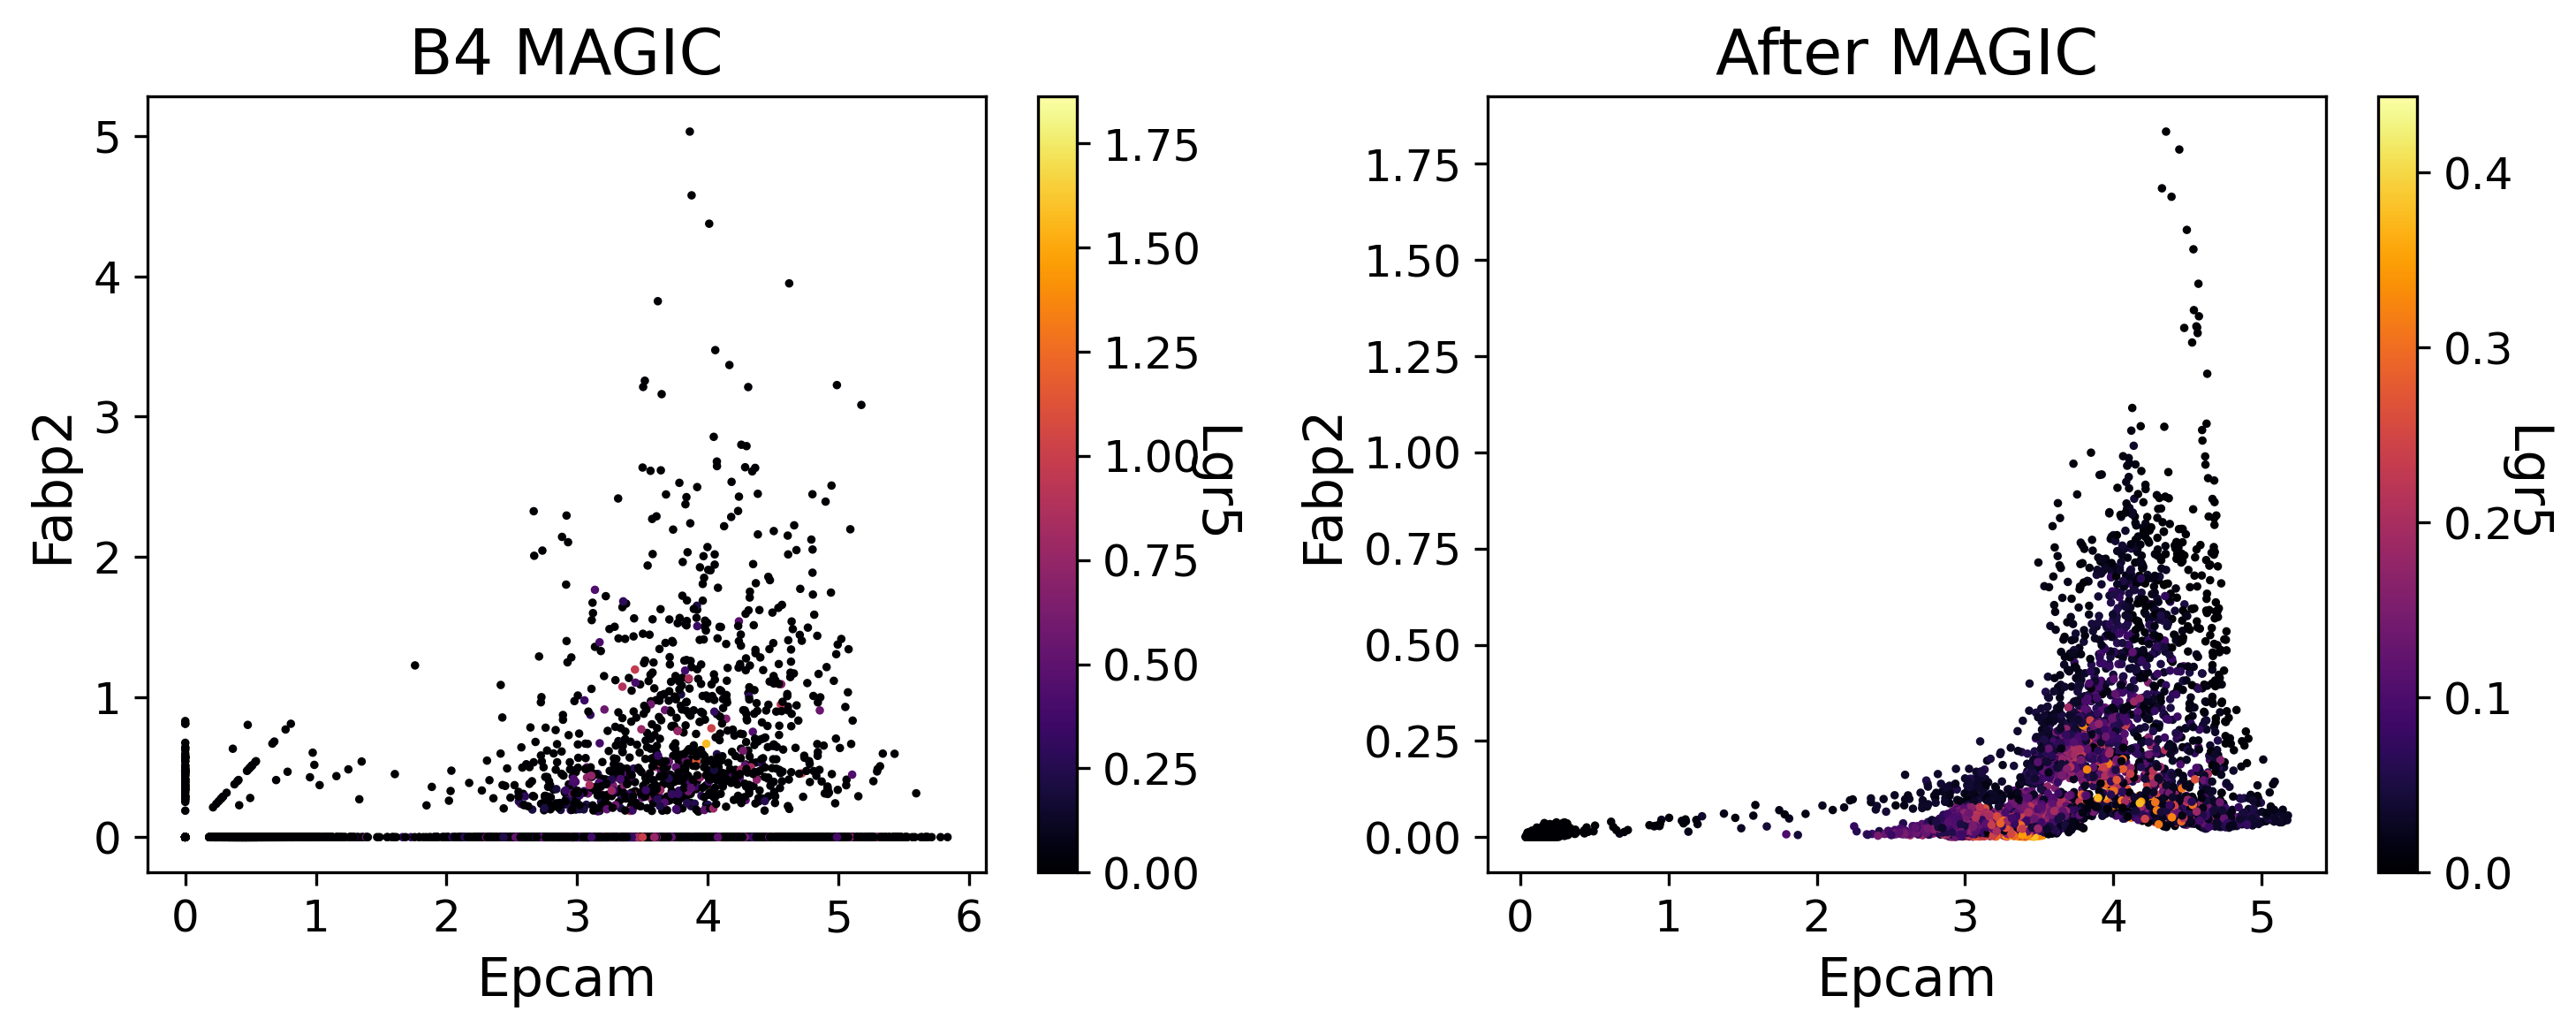

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), dpi=300)

scprep.plot.scatter(
    x=dRnaSeq_filt[mouse2human["Epcam"]], y=dRnaSeq_filt[mouse2human["Fabp2"]], 
    c=dRnaSeq_filt[mouse2human["Lgr5"]],
    xlabel="Epcam", ylabel="Fabp2", legend_title="Lgr5", 
    ax=ax1, title="B4 MAGIC")
scprep.plot.scatter(
    x=dMagicRnaSeq[mouse2human["Epcam"]], y=dMagicRnaSeq[mouse2human["Fabp2"]], 
    c=dMagicRnaSeq[mouse2human["Lgr5"]],
    xlabel="Epcam", ylabel="Fabp2", legend_title="Lgr5", 
    ax=ax2, title="After MAGIC")

plt.tight_layout()
plt.show()

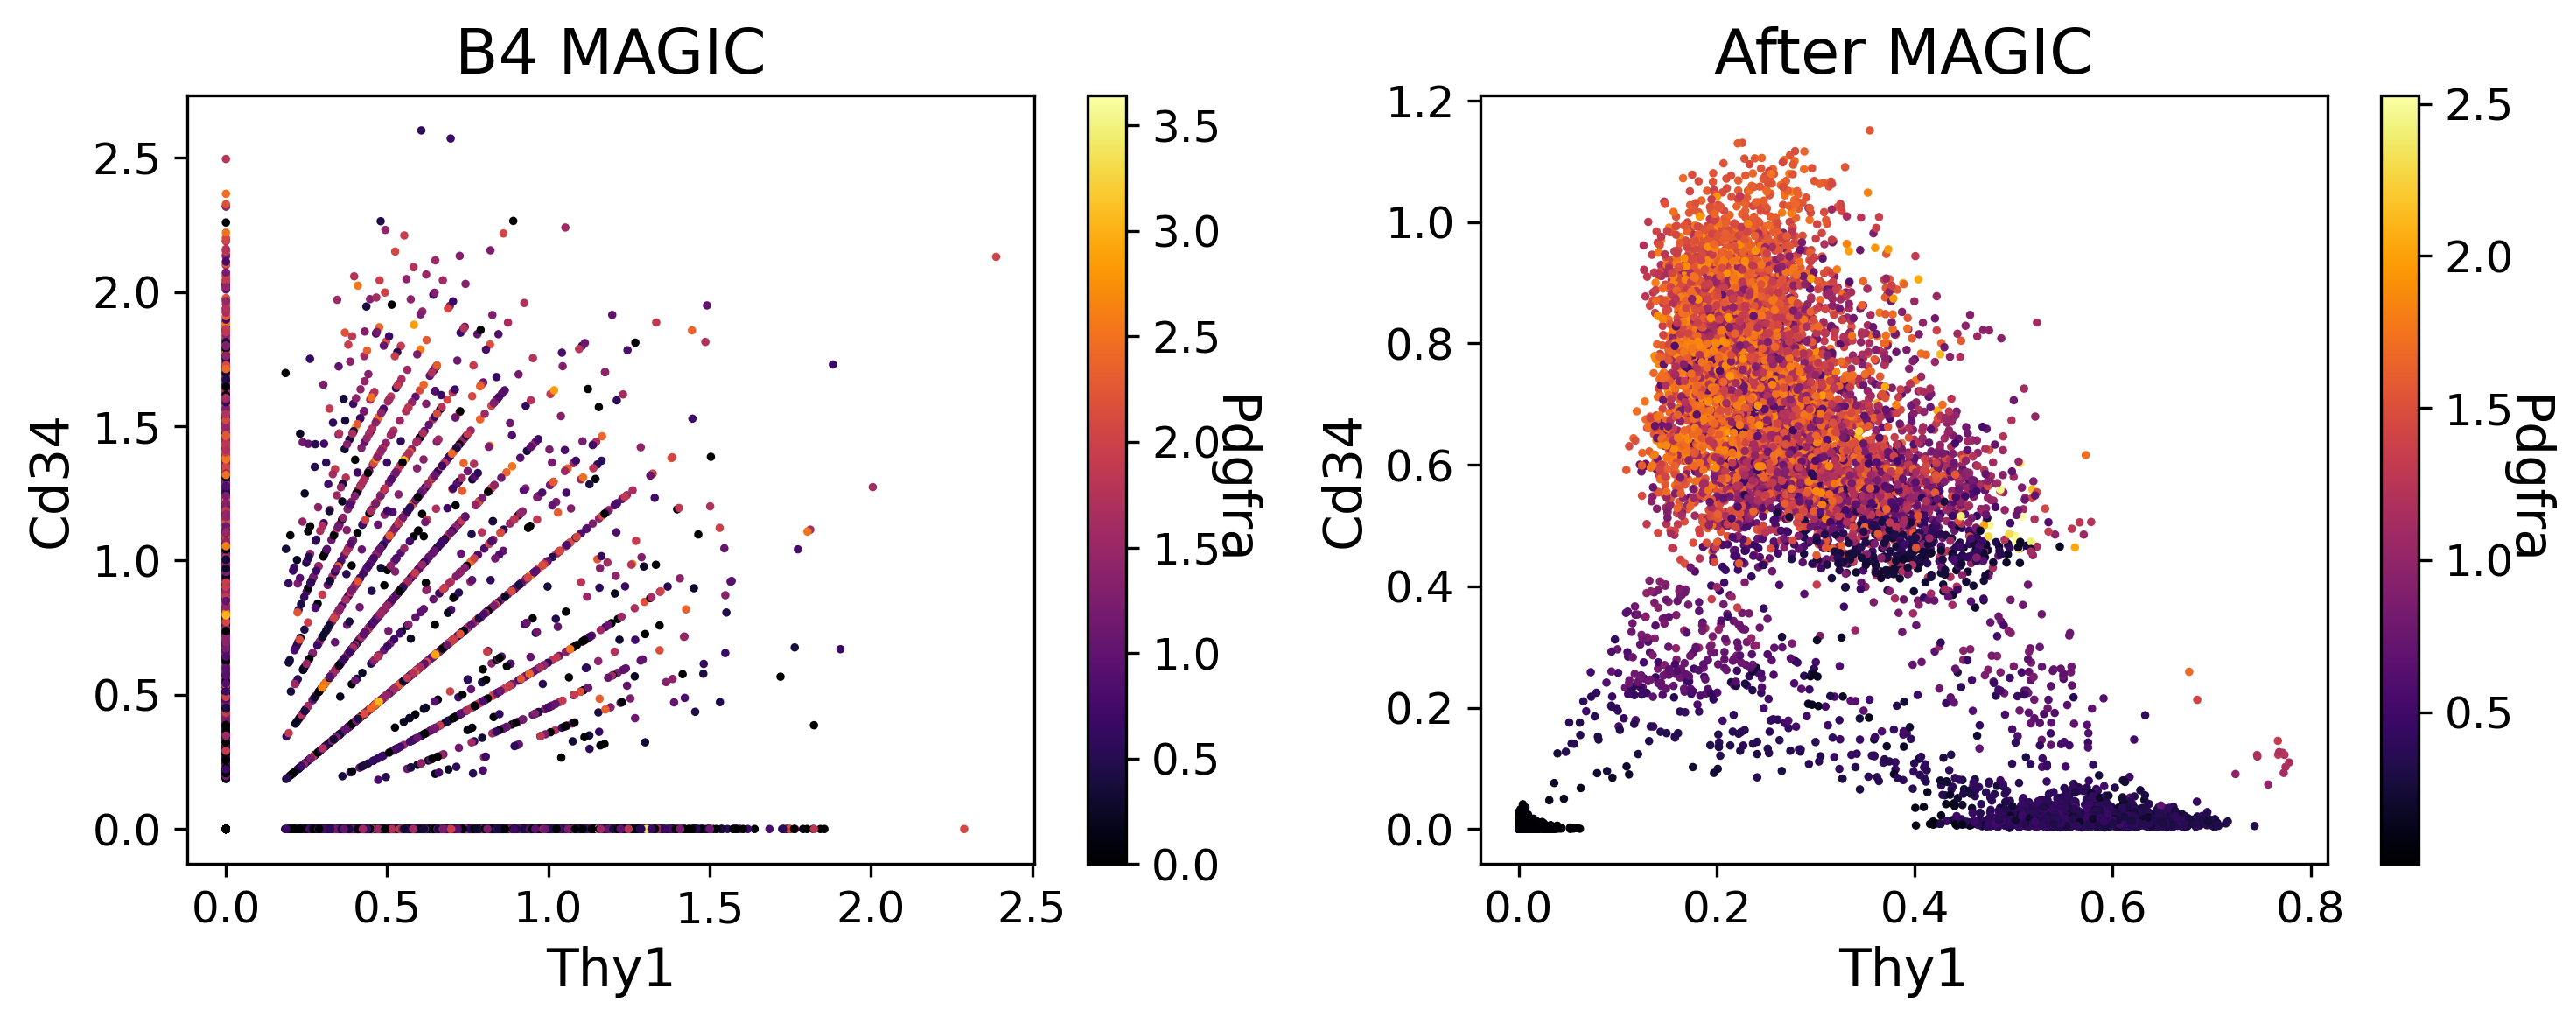

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), dpi=300)

scprep.plot.scatter(
    x=dRnaSeq_filt[mouse2human["Thy1"]], y=dRnaSeq_filt[mouse2human["Cd34"]], 
    c=dRnaSeq_filt[mouse2human["Pdgfra"]],
    xlabel="Thy1", ylabel="Cd34", legend_title="Pdgfra", 
    ax=ax1, title="B4 MAGIC")
scprep.plot.scatter(
    x=dMagicRnaSeq[mouse2human["Thy1"]], y=dMagicRnaSeq[mouse2human["Cd34"]], 
    c=dMagicRnaSeq[mouse2human["Pdgfra"]],
    xlabel="Thy1", ylabel="Cd34", legend_title="Pdgfra", 
    ax=ax2, title="After MAGIC")

plt.tight_layout()
plt.show()

In [36]:
del dRnaSeq_filt

Now, let's create a dataframe where gene expression values have been scalled row-wise (might be useful for the first DEMD approach, for wich we would need the gene expression arrays to summ up to the same value across all cells).

We can apply this scalling by computing the total sum of values for each row and then dividing the expression values for each gene in that cell by that sum.

In [30]:
#Cell-scalled GEX:
dScalRnaSeq = dMagicRnaSeq.div(dMagicRnaSeq.sum(axis=1), axis=0)
del dMagicRnaSeq
dScalRnaSeq

A1CF       A3GALT2        A4GALT         A4GNT  \
WT__AAACCCACAGCTTCCT-1   0.000000  3.749894e-07  1.913647e-04  0.000000e+00   
WT__AAACCCAGTTCGAGCC-1   0.000000  2.970447e-07  1.692386e-04  0.000000e+00   
WT__AAACGAAAGAAGGATG-1   0.000000  5.249822e-08  1.823751e-04  0.000000e+00   
WT__AAACGAAAGGAAAGGT-1   0.000067  0.000000e+00  5.641791e-07  0.000000e+00   
WT__AAACGAAAGTTAACGA-1   0.000011  9.978214e-09  1.708009e-06  0.000000e+00   
...                           ...           ...           ...           ...   
AKP__TTTGTTGAGGTATTGA-1  0.000000  5.846886e-07  1.812747e-04  0.000000e+00   
AKP__TTTGTTGCAGAACATA-1  0.000000  6.003176e-08  1.995005e-04  0.000000e+00   
AKP__TTTGTTGGTCGCATTA-1  0.000000  1.800713e-06  3.280992e-07  5.134215e-08   
AKP__TTTGTTGGTGTCTTCC-1  0.000000  0.000000e+00  3.840131e-07  1.598244e-06   
AKP__TTTGTTGTCAAGGAGC-1  0.000000  2.256832e-07  1.713033e-04  0.000000e+00   

                             AAAS      AACS         AADAC     AAGAB      AAK1  \
WT__AAACCCACAGCTTCCT-1   0.000031  0.000017  0.000000e+00  0.000028  0.000058   
WT__AAACCCAGTTCGAGCC-1   0.000030  0.000019  0.000000e+00  0.000032  0.000069   
WT__AAACGAAAGAAGGATG-1   0.000029  0.000032  0.000000e+00  0.000027  0.000064   
WT__AAACGAAAGGAAAGGT-1   0.000004  0.000013  2.941605e-06  0.000053  0.000039   
WT__AAACGAAAGTTAACGA-1   0.000015  0.000037  8.690711e-07  0.000032  0.000021   
...                           ...       ...           ...       ...       ...   
AKP__TTTGTTGAGGTATTGA-1  0.000014  0.000022  0.000000e+00  0.000024  0.000067   
AKP__TTTGTTGCAGAACATA-1  0.000024  0.000015  0.000000e+00  0.000030  0.000063   
AKP__TTTGTTGGTCGCATTA-1  0.000019  0.000056  0.000000e+00  0.000025  0.000023   
AKP__TTTGTTGGTGTCTTCC-1  0.000064  0.000073  0.000000e+00  0.000022  0.000025   
AKP__TTTGTTGTCAAGGAGC-1  0.000019  0.000016  0.000000e+00  0.000025  0.000070   

                            AAMDC  ...    ZSWIM8        ZSWIM9      ZW10  \
WT__AAACCCACAGCTTCCT-1   0.000106  ...  0.000041  8.293963e-06  0.000017   
WT__AAACCCAGTTCGAGCC-1   0.000084  ...  0.000033  8.730780e-06  0.000017   
WT__AAACGAAAGAAGGATG-1   0.000080  ...  0.000038  4.361893e-06  0.000023   
WT__AAACGAAAGGAAAGGT-1   0.000188  ...  0.000033  8.857567e-08  0.000010   
WT__AAACGAAAGTTAACGA-1   0.000139  ...  0.000022  5.144864e-06  0.000010   
...                           ...  ...       ...           ...       ...   
AKP__TTTGTTGAGGTATTGA-1  0.000091  ...  0.000049  4.106830e-06  0.000014   
AKP__TTTGTTGCAGAACATA-1  0.000099  ...  0.000044  3.790091e-06  0.000021   
AKP__TTTGTTGGTCGCATTA-1  0.000100  ...  0.000015  5.220061e-06  0.000012   
AKP__TTTGTTGGTGTCTTCC-1  0.000081  ...  0.000010  2.092288e-06  0.000022   
AKP__TTTGTTGTCAAGGAGC-1  0.000153  ...  0.000037  1.103779e-05  0.000014   

                               ZWILCH     ZWINT      ZXDC    ZYG11B       ZYX  \
WT__AAACCCACAGCTTCCT-1   1.144817e-06  0.000122  0.000026  0.000032  0.000142   
WT__AAACCCAGTTCGAGCC-1   7.792443e-06  0.000117  0.000032  0.000029  0.000148   
WT__AAACGAAAGAAGGATG-1   2.009799e-06  0.000140  0.000031  0.000029  0.000159   
WT__AAACGAAAGGAAAGGT-1   4.390824e-09  0.000104  0.000014  0.000029  0.000065   
WT__AAACGAAAGTTAACGA-1   1.635751e-06  0.000218  0.000011  0.000009  0.000061   
...                               ...       ...       ...       ...       ...   
AKP__TTTGTTGAGGTATTGA-1  1.483881e-06  0.000181  0.000023  0.000029  0.000178   
AKP__TTTGTTGCAGAACATA-1  8.893474e-07  0.000157  0.000034  0.000045  0.000159   
AKP__TTTGTTGGTCGCATTA-1  3.324558e-06  0.000113  0.000011  0.000016  0.000039   
AKP__TTTGTTGGTGTCTTCC-1  4.049878e-05  0.000144  0.000008  0.000015  0.000029   
AKP__TTTGTTGTCAAGGAGC-1  7.481008e-07  0.000210  0.000021  0.000039  0.000172   

                            ZZEF1      ZZZ3  
WT__AAACCCACAGCTTCCT-1   0.000035  0.000111  
WT__AAACCCAGTTCGAGCC-1   0.000030  0.000111  
WT__AAACGAAAGAAGGATG-1   0.000027  0.000099  
WT__AAACGAAAGGAAAGGT-1   0.000054  0.

# Wavelet dictionaries

## Wavelets on KG

From the gene-gene KG get a wavelet dictionary at multiscales based on gene expression.
The resulting gene**X**wavelet matrix can be multiplied against a gene**X**cell matrix (from scRNA-seq data) in order to project the cells onto the wavelets.

This approach should be able to incorporate proteomic data from CyTOF too, as PTMs will also be nodes on the graph and we will work with a node**X**wavelet matrix.

### Compute wavelets

First convert the current networkx graph (for now the 1st component) into a pygsp Graph.
That object can then be used by the wavelet code.

1- Using [networkx](https://networkx.org/documentation/stable/install.html) package.

    - From the integrated database, we've made a pandas dataframe that has only the 
    source and target columns and then use that to make a NetworkX Graph object 
    with `from_pandas_edgelist`

In [31]:
print(pygsp.__version__)

pyG = pygsp.graphs.Graph(W=networkx.to_numpy_array(G))
pyG

0.5.1


2022-10-06 16:52:18,785:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [32]:
wavloc = Localizer(pyG) #Takes only pygsp graphs
wavloc.CalculateWavelets(J=4) #J is the scale param. Confirmed
wavloc.FlattenAndNormalize()
wavloc.FlatWaves.shape

Calculating Wavelets Using J = 4


100%|██████████| 2/2 [00:29<00:00, 14.91s/it]


Flattening and Normalizing Wavelets


100%|██████████| 4/4 [00:19<00:00,  5.00s/it]


(13677, 54708)

Resulting object, accessed via .FlatWaves, is a gene**X**wavelet matrix

In [33]:
fuckers = [i for i in dScalRnaSeq.columns if i not in G.nodes()]

fuckers


[]

In [34]:
wavloc.FlatWaves

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.67975380e-05, -1.65167385e-04, -1.03103684e-04],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -3.27838801e-04, -3.57288939e-05,  1.34433840e-05],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
        -1.29705154e-04, -1.40662318e-04,  1.47644424e-04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.22523985e-01, -2.43782184e-06, -1.38736730e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.43185460e-06,  4.22241910e-01, -1.59280002e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.52042770e-07, -8.65519181e-07,  2.59019758e-01]])

### Project cells on geneXwavelet matrix

To project the cells on the gene**X**wavelet matrix we will multiply a cell**X**gene matrix by the gene**X**wavelet matrix, resulting in a cell**X**wavelet matrix

In [35]:
#Reorder GEX data based on adjacency matrix
dScalRnaSeq = dScalRnaSeq.reindex(
                columns=list(G.nodes())
                )
dScalRnaSeq

PPBP         CXCR2         CXCL6    CXCL16  \
WT__AAACCCACAGCTTCCT-1   5.441314e-08  3.616013e-08  3.072494e-05  0.000150   
WT__AAACCCAGTTCGAGCC-1   1.136179e-07  2.320849e-07  1.647750e-05  0.000135   
WT__AAACGAAAGAAGGATG-1   3.516346e-07  5.842152e-08  3.240649e-05  0.000183   
WT__AAACGAAAGGAAAGGT-1   0.000000e+00  0.000000e+00  3.251478e-06  0.000411   
WT__AAACGAAAGTTAACGA-1   1.668627e-06  1.301592e-09  3.626168e-05  0.000400   
...                               ...           ...           ...       ...   
AKP__TTTGTTGAGGTATTGA-1  8.645310e-08  0.000000e+00  5.148474e-05  0.000183   
AKP__TTTGTTGCAGAACATA-1  1.054779e-06  5.028748e-08  3.151182e-05  0.000208   
AKP__TTTGTTGGTCGCATTA-1  4.531698e-08  1.514493e-07  3.026906e-07  0.000047   
AKP__TTTGTTGGTGTCTTCC-1  3.288957e-09  3.585617e-07  1.133385e-07  0.000021   
AKP__TTTGTTGTCAAGGAGC-1  2.958481e-06  2.062165e-09  9.443811e-05  0.000017   

                                CXCR6    CX3CL1        CX3CR1      CCL2  \
WT__AAACCCACAGCTTCCT-1   0.000000e+00  0.000049  0.000000e+00  0.000609   
WT__AAACCCAGTTCGAGCC-1   0.000000e+00  0.000035  1.346436e-08  0.000618   
WT__AAACGAAAGAAGGATG-1   3.110659e-10  0.000066  7.013497e-09  0.000868   
WT__AAACGAAAGGAAAGGT-1   0.000000e+00  0.000028  0.000000e+00  0.000077   
WT__AAACGAAAGTTAACGA-1   0.000000e+00  0.000017  0.000000e+00  0.000051   
...                               ...       ...           ...       ...   
AKP__TTTGTTGAGGTATTGA-1  1.204191e-08  0.000040  3.552330e-08  0.000704   
AKP__TTTGTTGCAGAACATA-1  0.000000e+00  0.000035  2.264877e-09  0.000704   
AKP__TTTGTTGGTCGCATTA-1  0.000000e+00  0.000007  0.000000e+00  0.000031   
AKP__TTTGTTGGTGTCTTCC-1  0.000000e+00  0.000006  7.345457e-09  0.000028   
AKP__TTTGTTGTCAAGGAGC-1  0.000000e+00  0.000022  1.909788e-07  0.001115   

                                 CCR2      CCL7  ...  TRAV12-2   CEBPZOS  \
WT__AAACCCACAGCTTCCT-1   0.000000e+00  0.000722  ...  0.000000  0.000278   
WT__AAACCCAGTTCGAGCC-1   0.000000e+00  0.000692  ...  0.000000  0.000280   
WT__AAACGAAAGAAGGATG-1   0.000000e+00  0.000896  ...  0.000000  0.000293   
WT__AAACGAAAGGAAAGGT-1   0.000000e+00  0.000062  ...  0.000002  0.000237   
WT__AAACGAAAGTTAACGA-1   0.000000e+00  0.000059  ...  0.000001  0.000359   
...                               ...       ...  ...       ...       ...   
AKP__TTTGTTGAGGTATTGA-1  0.000000e+00  0.000645  ...  0.000000  0.000235   
AKP__TTTGTTGCAGAACATA-1  0.000000e+00  0.000705  ...  0.000000  0.000284   
AKP__TTTGTTGGTCGCATTA-1  1.181845e-09  0.000022  ...  0.000000  0.000278   
AKP__TTTGTTGGTGTCTTCC-1  8.140402e-09  0.000012  ...  0.000000  0.000268   
AKP__TTTGTTGTCAAGGAGC-1  5.980253e-09  0.000792  ...  0.000000  0.000256   

                           INAFM2        CFAP99       ANKRD62         AK4P3  \
WT__AAACCCACAGCTTCCT-1   0.000011  0.000000e+00  2.232952e-05  4.201101e-07   
WT__AAACCCAGTTCGAGCC-1   0.000011  0.000000e+00  2.509062e-05  3.990736e-07   
WT__AAACGAAAGAAGGATG-1   0.000013  3.667683e-08  2.415327e-05  4.014296e-06   
WT__AAACGAAAGGAAAGGT-1   0.000014  0.000000e+00  4.353586e-08  1.534019e-05   
WT__AAACGAAAGTTAACGA-1   0.000010  0.000000e+00  2.887201e-06  2.650334e-05   
...                           ...           ...           ...           ...   
AKP__TTTGTTGAGGTATTGA-1  0.000008  0.000000e+00  1.558212e-05  2.509191e-07   
AKP__TTTGTTGCAGAACATA-1  0.000009  0.000000e+00  2.215107e-05  9.572259e-07   
AKP__TTTGTTGGTCGCATTA-1  0.000013  0.000000e+00  6.282072e-06  4.608042e-05   
AKP__TTTGTTGGTGTCTTCC-1  0.000012  0.000000e+00  1.412960e-05  2.549178e-05   
AKP__TTTGTTGTCAAGGAGC-1  0.000010  0.000000e+00  1.839343e-05  2.339749e-06   

                           SMIM29      TOGARAM2         PCNX2      C1QTNF12  
WT__AAACCCACAGCTTCCT-1   0.000111  1.359686e-07  3.480590e-06  1.208650e-04  
WT__AAACCCAGTTCGAGCC-1   0.000102  2.529770e-07  4.084812e-06  1.154089e-04  
WT__AAACGAAAGAAGGATG-1   0.000115  4.119998e-08  3.916314e-06  1.259985e-04  
WT__AAACG

In [37]:
#Multiply 2 matrices using the dot product
cell_projection = np.dot(dScalRnaSeq, wavloc.FlatWaves)
cell_projection.shape #Shape should be 3.7k rows by 50k columns

(14546, 54708)

This is essentially a cell-cell graph based on their differences on the comns KG. 
We can thus use this to get some phate embeddings or any other downstream steps.

In [38]:
#Save to file as compressed npy object
np.savez_compressed(f"{data_dir}/cell_projection_nnKGwav_GEN.npz", cell_projection)

In [32]:
cell_projection = np.load(f"{data_dir}/cell_projection_nnKGwav_GEN.npz")["arr_0"]#Dict-like struct.Default arr_N keys
cell_projection.shape 

(3698, 52612)

## Rmv objects from mem

In [39]:
del wavloc,pyG,dKGnn_filt,dKGEnn_50filt

## Downstream 

#### Embed projections on PHATE

In [40]:
phate_op = phate.PHATE() 
data_phate = phate_op.fit_transform(cell_projection) 

Calculating PHATE...
  Running PHATE on 14546 observations and 54708 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 19.19 seconds.
    Calculating KNN search...
    Calculated KNN search in 5.72 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 24.98 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.66 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.63 seconds.
  Calculated landmark operator in 7.13 seconds.
  Calculating optimal t...
    Automatically selected t = 56
  Calculated optimal t in 1.62 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.35 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.52 seconds.
Calculated PHATE in 38.61 seconds.


In [41]:
print(data_phate.shape)
dCellEmbeddings = pd.DataFrame(data=data_phate, index = dScalRnaSeq.index, columns=["PHATE1","PHATE2"])
del phate_op,data_phate
dCellEmbeddings

(14546, 2)


PHATE1    PHATE2
WT__AAACCCACAGCTTCCT-1  -0.014076 -0.010938
WT__AAACCCAGTTCGAGCC-1  -0.014754 -0.011014
WT__AAACGAAAGAAGGATG-1  -0.013647 -0.012208
WT__AAACGAAAGGAAAGGT-1   0.027928  0.007357
WT__AAACGAAAGTTAACGA-1   0.030437  0.007096
...                           ...       ...
AKP__TTTGTTGAGGTATTGA-1 -0.012274 -0.000955
AKP__TTTGTTGCAGAACATA-1 -0.011040 -0.004466
AKP__TTTGTTGGTCGCATTA-1  0.018060 -0.017008
AKP__TTTGTTGGTGTCTTCC-1  0.013361 -0.018266
AKP__TTTGTTGTCAAGGAGC-1 -0.003014  0.020883

[14546 rows x 2 columns]

/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot: title={'center': 'Cells on communication KG (col=clust)'}, xlabel='PHATE1', ylabel='PHATE2'>

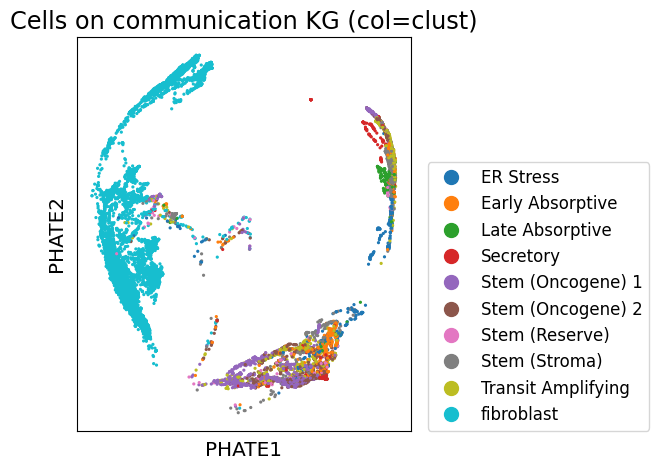

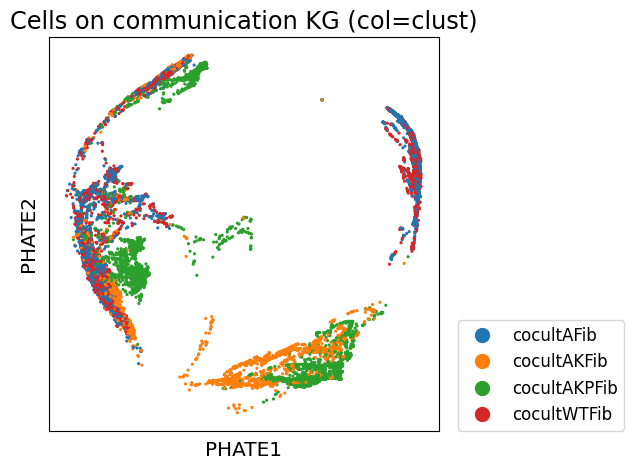

In [42]:
scprep.plot.scatter2d(
    dCellEmbeddings, c=dSEQmd["finalPOPS"],
    title="Cells on communication KG (col=clust)", ticks=None,
    legend_loc=(1.05, 0))
    
scprep.plot.scatter2d(
    dCellEmbeddings, c=dSEQmd["orig.ident"],
    title="Cells on communication KG (col=clust)", ticks=None,
    legend_loc=(1.05, 0))

##### Results

Using the wavelet approach we get a very similar PHATE space as that from the DEMD approach. 

Before continuing further we should explore some kind of tunning of the KG, perhaps aiminig to *sparsify* it?